# Testing loforest tuning and comparing to several K

In [41]:
# importing packages
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import itertools

# font size
sns.set_style("white", rc={"font_scale": 1.5})

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest, tune_loforest_LFI
from CP2LFI.scores import LambdaScore

from clover import Scores
from clover import LocartSplit

from copy import deepcopy
from tqdm import tqdm

from scipy import stats
from scipy.optimize import minimize_scalar

import colorcet as cc

import time

## BFF setting

In [55]:
# BFF functions
def sim_X(n, theta, rng):
    X = rng.normal(theta, 1, n)
    return X

def sim_lambda(B, N, theta, rng, sigma=0.25):
    lambdas = np.zeros(B)
    for i in range(0, B):
        X = sim_X(N, theta, rng)
        lambdas[i] = compute_pdf_posterior(theta, X, sigma=sigma)
    return lambdas

def sample_posterior(n, N, rng, sigma=0.25):
    thetas = rng.uniform(-5, 5, size=n)
    lambdas = np.zeros(n)
    i = 0
    for theta in thetas:
        X = sim_X(N, theta, rng)
        lambdas[i] = compute_pdf_posterior(theta, X, sigma=sigma)
        i += 1
    return thetas, lambdas

def compute_pdf_posterior(theta, x, sigma=0.25):
    n = x.shape[0]
    mu_value = (1 / ((1 / sigma) + n)) * (np.sum(x))
    sigma_value = ((1 / sigma) + n) ** (-1)
    return -stats.norm.pdf(theta, loc=mu_value, scale=np.sqrt(sigma_value))

# naive method
def naive(alpha, rng, B=1000, N=100, lower=-5, upper=5, naive_n=100, sigma=0.25):
    n_grid = int(B / naive_n)
    thetas = np.linspace(lower, upper, n_grid)
    quantiles = {}
    for theta in thetas:
        lambdas = sim_lambda(naive_n, N, theta, rng, sigma=sigma)
        quantiles[theta] = np.quantile(lambdas, q=1 - alpha)
    return quantiles

# naive predict function
def predict_naive_quantile(theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for theta in theta_grid:
        idx = thetas_values[int(np.argmin(np.abs(theta - thetas_values)))]
        quantiles_list.append(quantiles_dict[idx])
    return quantiles_list

# obtaining quantile for a specific K in loforest
def obtain_quantiles(
    thetas,
    N,
    rng,
    B=1000,
    alpha=0.05,
    sigma=0.25,
    min_samples_leaf=300,
    K = 50,
    tune_k = True,
    n_estimators = 200,
    step = 5,
    pct_cover = 0.95,
    min_samples = 300
):
    # simulating to fit models
    theta_sim, model_lambdas = sample_posterior(n=B, N=N, rng=rng, sigma=sigma)
    model_thetas = theta_sim.reshape(-1, 1)
    # loforest quantiles
    start_time = time.time()
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False, tune_K = tune_k
    )
    loforest_object.calibrate(
        model_thetas, model_lambdas, min_samples_leaf=min_samples_leaf, K=K, n_estimators=n_estimators
    )
    
    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1), min_samples = min_samples, step = step, pct_cover = pct_cover)
    end_time = time.time()

    running_time = end_time - start_time
    print(f"Loforest took {running_time} seconds to run.")

    # dictionary of quantiles
    if tune_k == True:
        K = "tuned"
    
    print(f"Tuned K: {loforest_object.K}")
        
    quantile_dict = {
        "loforest_{}".format(K) : loforest_cutoffs,
    }

    return quantile_dict

First, we will test the tuned loforest performance and running time:

In [56]:
def evaluate_coverage_N_tuned_loforest(
        seed = 45,
        n_out = 300,
        n = 1000,
        N = np.array([1, 10, 20, 50]), 
        B = 5000, 
        alpha = 0.05,
        sigma=0.25, 
        min_samples_leaf=300, 
        K=50,
        tune_K = True,
        min_samples = 300,
        pct_cover = 0.95,
        step = 5):
    rng = np.random.default_rng(seed)
    # generate testing grid
    thetas = np.linspace(-4.999, 4.999, n_out)
    N_list = []
    mae_list = []
    se_list = []
    B_list = []
    methods_list = []

    for N_fixed in N:
        err_data = np.zeros((thetas.shape[0], 1))

        # Obtain the quantiles
        quantiles_dict = obtain_quantiles(
            thetas = thetas, 
            N = N_fixed, 
            rng = rng, 
            B=B, 
            alpha=alpha, 
            sigma=sigma, 
            min_samples_leaf=min_samples_leaf, 
            K=K, 
            tune_k = tune_K,
            step = step,
            pct_cover = pct_cover,
            min_samples = min_samples
            )

        # Check if the true lambda values fall within the predicted quantiles
        i = 0
        for theta in thetas:
            lambda_stat = sim_lambda(
                B=n,
                N=N_fixed,
                theta=theta,
                sigma=sigma,
                rng = rng,
                )
            if tune_K:
                coverage = np.mean(lambda_stat <= quantiles_dict["loforest_tuned"][i])
            else:
                coverage = np.mean(lambda_stat <= quantiles_dict["loforest_{}".format(K)][i])

            err_data[i, :] = np.array([np.abs(coverage - (1 - alpha)) ])
            i += 1
        
        if tune_K:
            methods_list.extend(["loforest_tuned"])
        else:
            methods_list.extend(["loforest_{}".format(K)])
        mae_list.extend(np.mean(err_data, axis=0).tolist())
        se_list.extend((np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))).tolist())
        N_list.extend([N_fixed])
        B_list.extend([B])
    
    if tune_K:
        stats_data = pd.DataFrame(
        {
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    else:
        stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

Fixing $K = 50$ and comparing to the tuned one:

In [57]:
start_time = time.time()
stats_df = evaluate_coverage_N_tuned_loforest(B = 5000, n = 2000, min_samples = 100, pct_cover = 0.95, min_samples_leaf = 100, K = 50, tune_K = False)
end_time = time.time()

running_time = end_time - start_time
print(f"The simulation took {running_time} seconds to run.")

Loforest took 1.8778064250946045 seconds to run.
Tuned K: 50
Loforest took 1.8969686031341553 seconds to run.
Tuned K: 50
Loforest took 1.8711588382720947 seconds to run.
Tuned K: 50
Loforest took 1.8574192523956299 seconds to run.
Tuned K: 50
The simulation took 151.43603992462158 seconds to run.


In [58]:
stats_df

,methods,N,B,MAE,se
0,loforest_50,1,5000,0.070510,0.005096
1,loforest_50,10,5000,0.072573,0.004337
2,loforest_50,20,5000,0.055515,0.002296
3,loforest_50,50,5000,0.050728,0.002102


Now, analysing the tuning results:

In [59]:
start_time = time.time()
stats_df = evaluate_coverage_N_tuned_loforest(B = 5000, n = 2000, min_samples = 100, pct_cover = 1, min_samples_leaf = 100, K = 50, tune_K = True)
end_time = time.time()

running_time = end_time - start_time
print(f"The simulation took {running_time} seconds to run.")

Loforest took 1.9047048091888428 seconds to run.
Tuned K: 105
Loforest took 1.7245514392852783 seconds to run.
Tuned K: 105
Loforest took 1.8848514556884766 seconds to run.
Tuned K: 110
Loforest took 1.794950246810913 seconds to run.
Tuned K: 115
The simulation took 150.63796424865723 seconds to run.


In [60]:
stats_df

,N,B,MAE,se
0,1,5000,0.070567,0.005105
1,10,5000,0.072573,0.004337
2,20,5000,0.055515,0.002296
3,50,5000,0.053462,0.002353


## Exponential setting:

In [61]:
def sim_lambda(theta, rng, B = 1000, N = 100):
    lambdas = np.zeros(B)
    theoretical = np.e**(-theta)
    for k in range(0, B):
        exp = rng.exponential(1/theta, N)
        empirical = len([i for i in exp if i > 1])/len(exp)
        lambdas[k] = np.abs(theoretical - empirical)
    return lambdas

def train_naive(alpha, rng, B = 1000, N = 100, naive_n = 500, lower = 0.0001, upper = 6.9999):
    # simulating by a fixed theta_grid with size compatible with the amount of samples 
    # we want to simulate
    n_grid = int(B / naive_n)
    if n_grid > 1:
        step = (upper - lower)/n_grid
        thetas_fixed = np.arange(lower, upper, step)
    else:
        step = (upper - lower)/2
        thetas_fixed = np.array([np.arange(lower, upper, step)[1]])
      
    thetas_fixed = np.linspace(lower, upper, n_grid)
    
    quantiles = {}
    for theta in thetas_fixed:
        diff = sim_lambda(theta, B = n_grid, N = N, rng = rng)
        quantiles[theta] = np.quantile(diff, q = 1 - alpha)
    return quantiles

def predict_naive_quantile(theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for theta in theta_grid:
        idx = thetas_values[int(np.argmin(np.abs(theta - thetas_values)))]
        quantiles_list.append(quantiles_dict[idx])
    return quantiles_list
  
def generate_parameters_random(rng, B = 5000, N = 1000):
    random_theta_grid = rng.uniform(0, 7, B)
    lambdas = np.zeros(B)
    i = 0
    for theta in random_theta_grid:
        theoretical = np.e**(-theta)
        exp = rng.exponential(1/theta, N)
        empirical = (len([i for i in exp if i > 1])/len(exp))
        lambdas[i] = np.abs(theoretical - empirical)
        i += 1
    return random_theta_grid, lambdas

def obtain_quantiles(
    thetas,
    N,
    rng,
    B=1000,
    alpha=0.05,
    min_samples_leaf=300,
    K = 50,
    tune_k = True,
    step = 5,
    pct_cover = 0.95,
    min_samples = 300
):
    # simulating to fit models
    theta_sim, model_lambdas = generate_parameters_random(B = B, rng = rng, N = N)
    model_thetas = theta_sim.reshape(-1, 1)

    # loforest quantiles
    start_time = time.time()
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False, tune_K = tune_k
    )
    loforest_object.calibrate(
        model_thetas, model_lambdas, min_samples_leaf=min_samples_leaf, K=K, n_estimators=200
    )
    
    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1), 
                                                       step = step, 
                                                       pct_cover = pct_cover, 
                                                       min_samples = min_samples)
    end_time = time.time()

    running_time = end_time - start_time
    print(f"Loforest took {running_time} seconds to run.")

    # dictionary of quantiles
    if tune_k == True:
        K = "tuned"
    
    print(f"Tuned K: {loforest_object.K}")
        
    quantile_dict = {
        "loforest_{}".format(K) : loforest_cutoffs,
    }

    return quantile_dict

In [62]:
def evaluate_coverage_N_tuned_loforest(
        seed = 45,
        n_out = 500,
        n = 1000,
        N = np.array([1, 10, 20, 50, 100, 1000]), 
        B = 5000, 
        alpha = 0.05,
        min_samples_leaf=300, 
        K=50,
        tune_K = True,
        pct_cover = 0.95,
        step = 5,
        min_samples = 300,):
    rng = np.random.default_rng(seed)
    # generate testing grid
    thetas = np.linspace(0.0001, 6.9999, n_out)
    N_list = []
    mae_list = []
    se_list = []
    B_list = []
    methods_list = []

    for N_fixed in N:
        err_data = np.zeros((thetas.shape[0], 1))

        # Obtain the quantiles
        quantiles_dict = obtain_quantiles(
            thetas, 
            N_fixed, 
            rng, 
            B=B, 
            alpha=alpha, 
            min_samples_leaf=min_samples_leaf, 
            K=K, 
            tune_k = tune_K, 
            pct_cover= pct_cover,
            step = step,
            min_samples = min_samples,)

        # Check if the true lambda values fall within the predicted quantiles
        i = 0
        for theta in thetas:
            lambda_stat = sim_lambda(
                B=n,
                N=N_fixed,
                theta=theta,
                rng = rng,
                )
            if tune_K:
                coverage = np.mean(lambda_stat <= quantiles_dict["loforest_tuned"][i])
            else:
                coverage = np.mean(lambda_stat <= quantiles_dict["loforest_{}".format(K)][i])

            err_data[i, :] = np.array([np.abs(coverage - (1 - alpha))])
            i += 1
        
        if tune_K:
            methods_list.extend(["loforest_tuned"])
        else:
            methods_list.extend(["loforest_{}".format(K)])
        mae_list.extend(np.mean(err_data, axis=0).tolist())
        se_list.extend((np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))).tolist())
        N_list.extend([N_fixed])
        B_list.extend([B])
    
    if tune_K:
        stats_data = pd.DataFrame(
        {
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    else:
        stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

In [63]:
start_time = time.time()
stats_df = evaluate_coverage_N_tuned_loforest(B = 5000, n = 2000, min_samples = 100, pct_cover = 1, min_samples_leaf = 100, K = 50, tune_K = False)
end_time = time.time()

running_time = end_time - start_time
print(f"The simulation took {running_time} seconds to run.")

Loforest took 4.179127931594849 seconds to run.
Tuned K: 50
Loforest took 4.271272420883179 seconds to run.
Tuned K: 50
Loforest took 4.22680139541626 seconds to run.
Tuned K: 50
Loforest took 4.186808824539185 seconds to run.
Tuned K: 50
Loforest took 4.1800618171691895 seconds to run.
Tuned K: 50
Loforest took 4.2613749504089355 seconds to run.
Tuned K: 50
The simulation took 110.05889654159546 seconds to run.


In [64]:
stats_df

,methods,N,B,MAE,se
0,loforest_50,1,5000,0.064404,0.002820
1,loforest_50,10,5000,0.060228,0.001914
2,loforest_50,20,5000,0.063925,0.002138
3,loforest_50,50,5000,0.068529,0.002256
4,loforest_50,100,5000,0.067488,0.002172
5,loforest_50,1000,5000,0.057014,0.001389


In [65]:
start_time = time.time()
stats_df = evaluate_coverage_N_tuned_loforest(B = 5000, n = 2000, min_samples = 100, pct_cover = 1, min_samples_leaf = 100, K = 50, tune_K = True)
end_time = time.time()

running_time = end_time - start_time
print(f"The simulation took {running_time} seconds to run.")

Loforest took 4.302614212036133 seconds to run.
Tuned K: 100
Loforest took 4.162890672683716 seconds to run.
Tuned K: 105
Loforest took 3.89399790763855 seconds to run.
Tuned K: 110
Loforest took 3.985732316970825 seconds to run.
Tuned K: 105
Loforest took 3.924908399581909 seconds to run.
Tuned K: 100
Loforest took 4.084616661071777 seconds to run.
Tuned K: 105
The simulation took 106.88781714439392 seconds to run.


In [66]:
stats_df

,N,B,MAE,se
0,1,5000,0.066452,0.002980
1,10,5000,0.062445,0.002209
2,20,5000,0.063827,0.002122
3,50,5000,0.072970,0.002569
4,100,5000,0.068830,0.002271
5,1000,5000,0.056691,0.001365


# Testing loforest alternative tuning and comparing to other K's:

## BFF example:

In [2]:
# BFF functions
def sim_X(n, theta, rng):
    X = rng.normal(theta, 1, n)
    return X

def sim_lambda(B, N, theta, rng, sigma=0.25):
    lambdas = np.zeros(B)
    for i in range(0, B):
        X = sim_X(N, theta, rng)
        lambdas[i] = compute_pdf_posterior(theta, X, sigma=sigma)
    return lambdas

def sample_posterior(n, N, rng, sigma=0.25):
    thetas = rng.uniform(-5, 5, size=n)
    lambdas = np.zeros(n)
    i = 0
    for theta in thetas:
        X = sim_X(N, theta, rng)
        lambdas[i] = compute_pdf_posterior(theta, X, sigma=sigma)
        i += 1
    return thetas, lambdas

def compute_pdf_posterior(theta, x, sigma=0.25):
    n = x.shape[0]
    mu_value = (1 / ((1 / sigma) + n)) * (np.sum(x))
    sigma_value = ((1 / sigma) + n) ** (-1)
    return -stats.norm.pdf(theta, loc=mu_value, scale=np.sqrt(sigma_value))

# naive method
def naive(alpha, rng, B=1000, N=100, lower=-5, upper=5, naive_n=100, sigma=0.25):
    n_grid = int(B / naive_n)
    thetas = np.linspace(lower, upper, n_grid)
    quantiles = {}
    for theta in thetas:
        lambdas = sim_lambda(naive_n, N, theta, rng, sigma=sigma)
        quantiles[theta] = np.quantile(lambdas, q=1 - alpha)
    return quantiles

# naive predict function
def predict_naive_quantile(theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for theta in theta_grid:
        idx = thetas_values[int(np.argmin(np.abs(theta - thetas_values)))]
        quantiles_list.append(quantiles_dict[idx])
    return quantiles_list

# obtaining quantile for a specific K in loforest
def obtain_quantiles(
    thetas,
    N,
    rng,
    B=1000,
    B_valid = 1000,
    N_lambda = 500,
    alpha=0.05,
    sigma=0.25,
    min_samples_leaf=300,
    K = 50,
    K_grid = np.arange(30, 85, 5),
    n_estimators = 200,
):
    # training set of thetas and lambdas
    theta_sim, model_lambdas = sample_posterior(n=B, N=N, rng=rng, sigma=sigma)
    model_thetas = theta_sim.reshape(-1, 1)
    # loforest quantiles
    start_time = time.time()
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False, tune_K = False
    )
    loforest_object.calibrate(
        model_thetas, model_lambdas, min_samples_leaf=min_samples_leaf, K=K, n_estimators=n_estimators
    )
    
    # validation set of thetas and lambdas
    theta_valid, _ = sample_posterior(n=B_valid, N=N, rng=rng, sigma=sigma)
    model_thetas_valid = theta_valid.reshape(-1, 1)
    lambda_valid = np.zeros((theta_valid.shape[0],N_lambda))
    i = 0
    for theta_fixed in theta_valid:
        lambda_valid[i, :] = sim_lambda(B = N_lambda, N = N, theta = theta_fixed, rng = rng, sigma = sigma)
        i += 1
    
    start_tune = time.time()
    # tuning K using validation set
    K_loforest = tune_loforest_LFI(loforest_object, model_thetas_valid, lambda_valid, K_grid = K_grid)
    end_tune = time.time()

    running_tune = end_tune - start_tune
    print(f"Tuning took {running_tune} seconds to run for N = {N} and B = {B}.")
    

    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1), K = K_loforest)
    end_time = time.time()

    running_time = end_time - start_time
    print(f"Loforest took {running_time} seconds to run.")
        
    quantile_dict = {
        "loforest_tuned": loforest_cutoffs,
    }

    return quantile_dict, K_loforest

In [3]:
def evaluate_coverage_N_tuned_loforest(
        seed = 45,
        n_out = 300,
        n = 1000,
        N = np.array([1, 10, 20, 50]),
        B=np.array([500, 1000, 5000, 10000, 15000, 20000]),
        alpha = 0.05,
        sigma=0.25, 
        min_samples_leaf=300, 
        K=50,
        K_grid = np.arange(30, 85, 5),
        B_valid = 1000,
        N_lambda = 750,
        ):
    rng = np.random.default_rng(seed)
    # generate testing grid
    thetas = np.linspace(-4.999, 4.999, n_out)
    N_list = []
    mae_list = []
    se_list = []
    B_list = []
    K_list = []

    for N_fixed in N:
        for B_fixed in B:
            # Obtain the quantiles
            quantiles_dict, K_loforest = obtain_quantiles(
                thetas = thetas, 
                N = N_fixed, 
                rng = rng, 
                B=B_fixed, 
                alpha=alpha, 
                sigma=sigma, 
                min_samples_leaf=min_samples_leaf,
                K = K,
                K_grid = K_grid,
                B_valid = B_valid,
                N_lambda = N_lambda,
                )
            
            err_data = np.zeros((thetas.shape[0], 1))
            
            print("tuned K = {}".format(K_loforest))

            # Check if the true lambda values fall within the predicted quantiles
            i = 0
            for theta in thetas:
                lambda_stat = sim_lambda(
                    B=n,
                    N=N_fixed,
                    theta=theta,
                    sigma=sigma,
                    rng = rng,
                    )
                
                coverage = np.mean(lambda_stat <= quantiles_dict["loforest_tuned"][i])

                err_data[i, :] = np.array([np.abs(coverage - (1 - alpha)) ])
                i += 1
            
            
            K_list.extend([K_loforest])
            mae_list.extend(np.mean(err_data, axis=0).tolist())
            se_list.extend((np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))).tolist())
            N_list.extend([N_fixed])
            B_list.extend([B_fixed])
        
    stats_data = pd.DataFrame(
        {
            "K": K_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

In [6]:
start_time = time.time()
stats_df = evaluate_coverage_N_tuned_loforest(
    B = np.array([500, 1000, 5000, 10000, 15000, 20000]), 
    n_out = 500, 
    n = 1000, 
    min_samples_leaf = 300, 
    K = 50,
    K_grid = np.arange(30, 90, 5), 
    B_valid = 1000,
    )
end_time = time.time()

running_time = end_time - start_time
print(f"The simulation took {running_time} seconds to run.")

Tuning took 0.9354293346405029 seconds to run for N = 1 and B = 500.
Loforest took 47.91647505760193 seconds to run.
tuned K = 30
Tuning took 1.0233583450317383 seconds to run for N = 1 and B = 1000.
Loforest took 47.2081995010376 seconds to run.
tuned K = 75
Tuning took 1.6927790641784668 seconds to run for N = 1 and B = 5000.
Loforest took 47.829113245010376 seconds to run.
tuned K = 35
Tuning took 2.639803171157837 seconds to run for N = 1 and B = 10000.
Loforest took 48.335901737213135 seconds to run.
tuned K = 50
Tuning took 3.7038376331329346 seconds to run for N = 1 and B = 15000.
Loforest took 52.824968099594116 seconds to run.
tuned K = 30
Tuning took 4.803009033203125 seconds to run for N = 1 and B = 20000.
Loforest took 54.83406066894531 seconds to run.
tuned K = 40
Tuning took 0.9685020446777344 seconds to run for N = 10 and B = 500.
Loforest took 47.5873236656189 seconds to run.
tuned K = 30
Tuning took 1.0689361095428467 seconds to run for N = 10 and B = 1000.
Loforest to

In [8]:
stats_df.head(5)

,K,N,B,MAE,se
0,30,1,500,0.082516,0.005454
1,75,1,1000,0.084112,0.005678
2,35,1,5000,0.047678,0.001386
3,50,1,10000,0.040672,0.001630
4,30,1,15000,0.039038,0.001903


Plotting loss across several B and N:

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_116254/1101952012.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


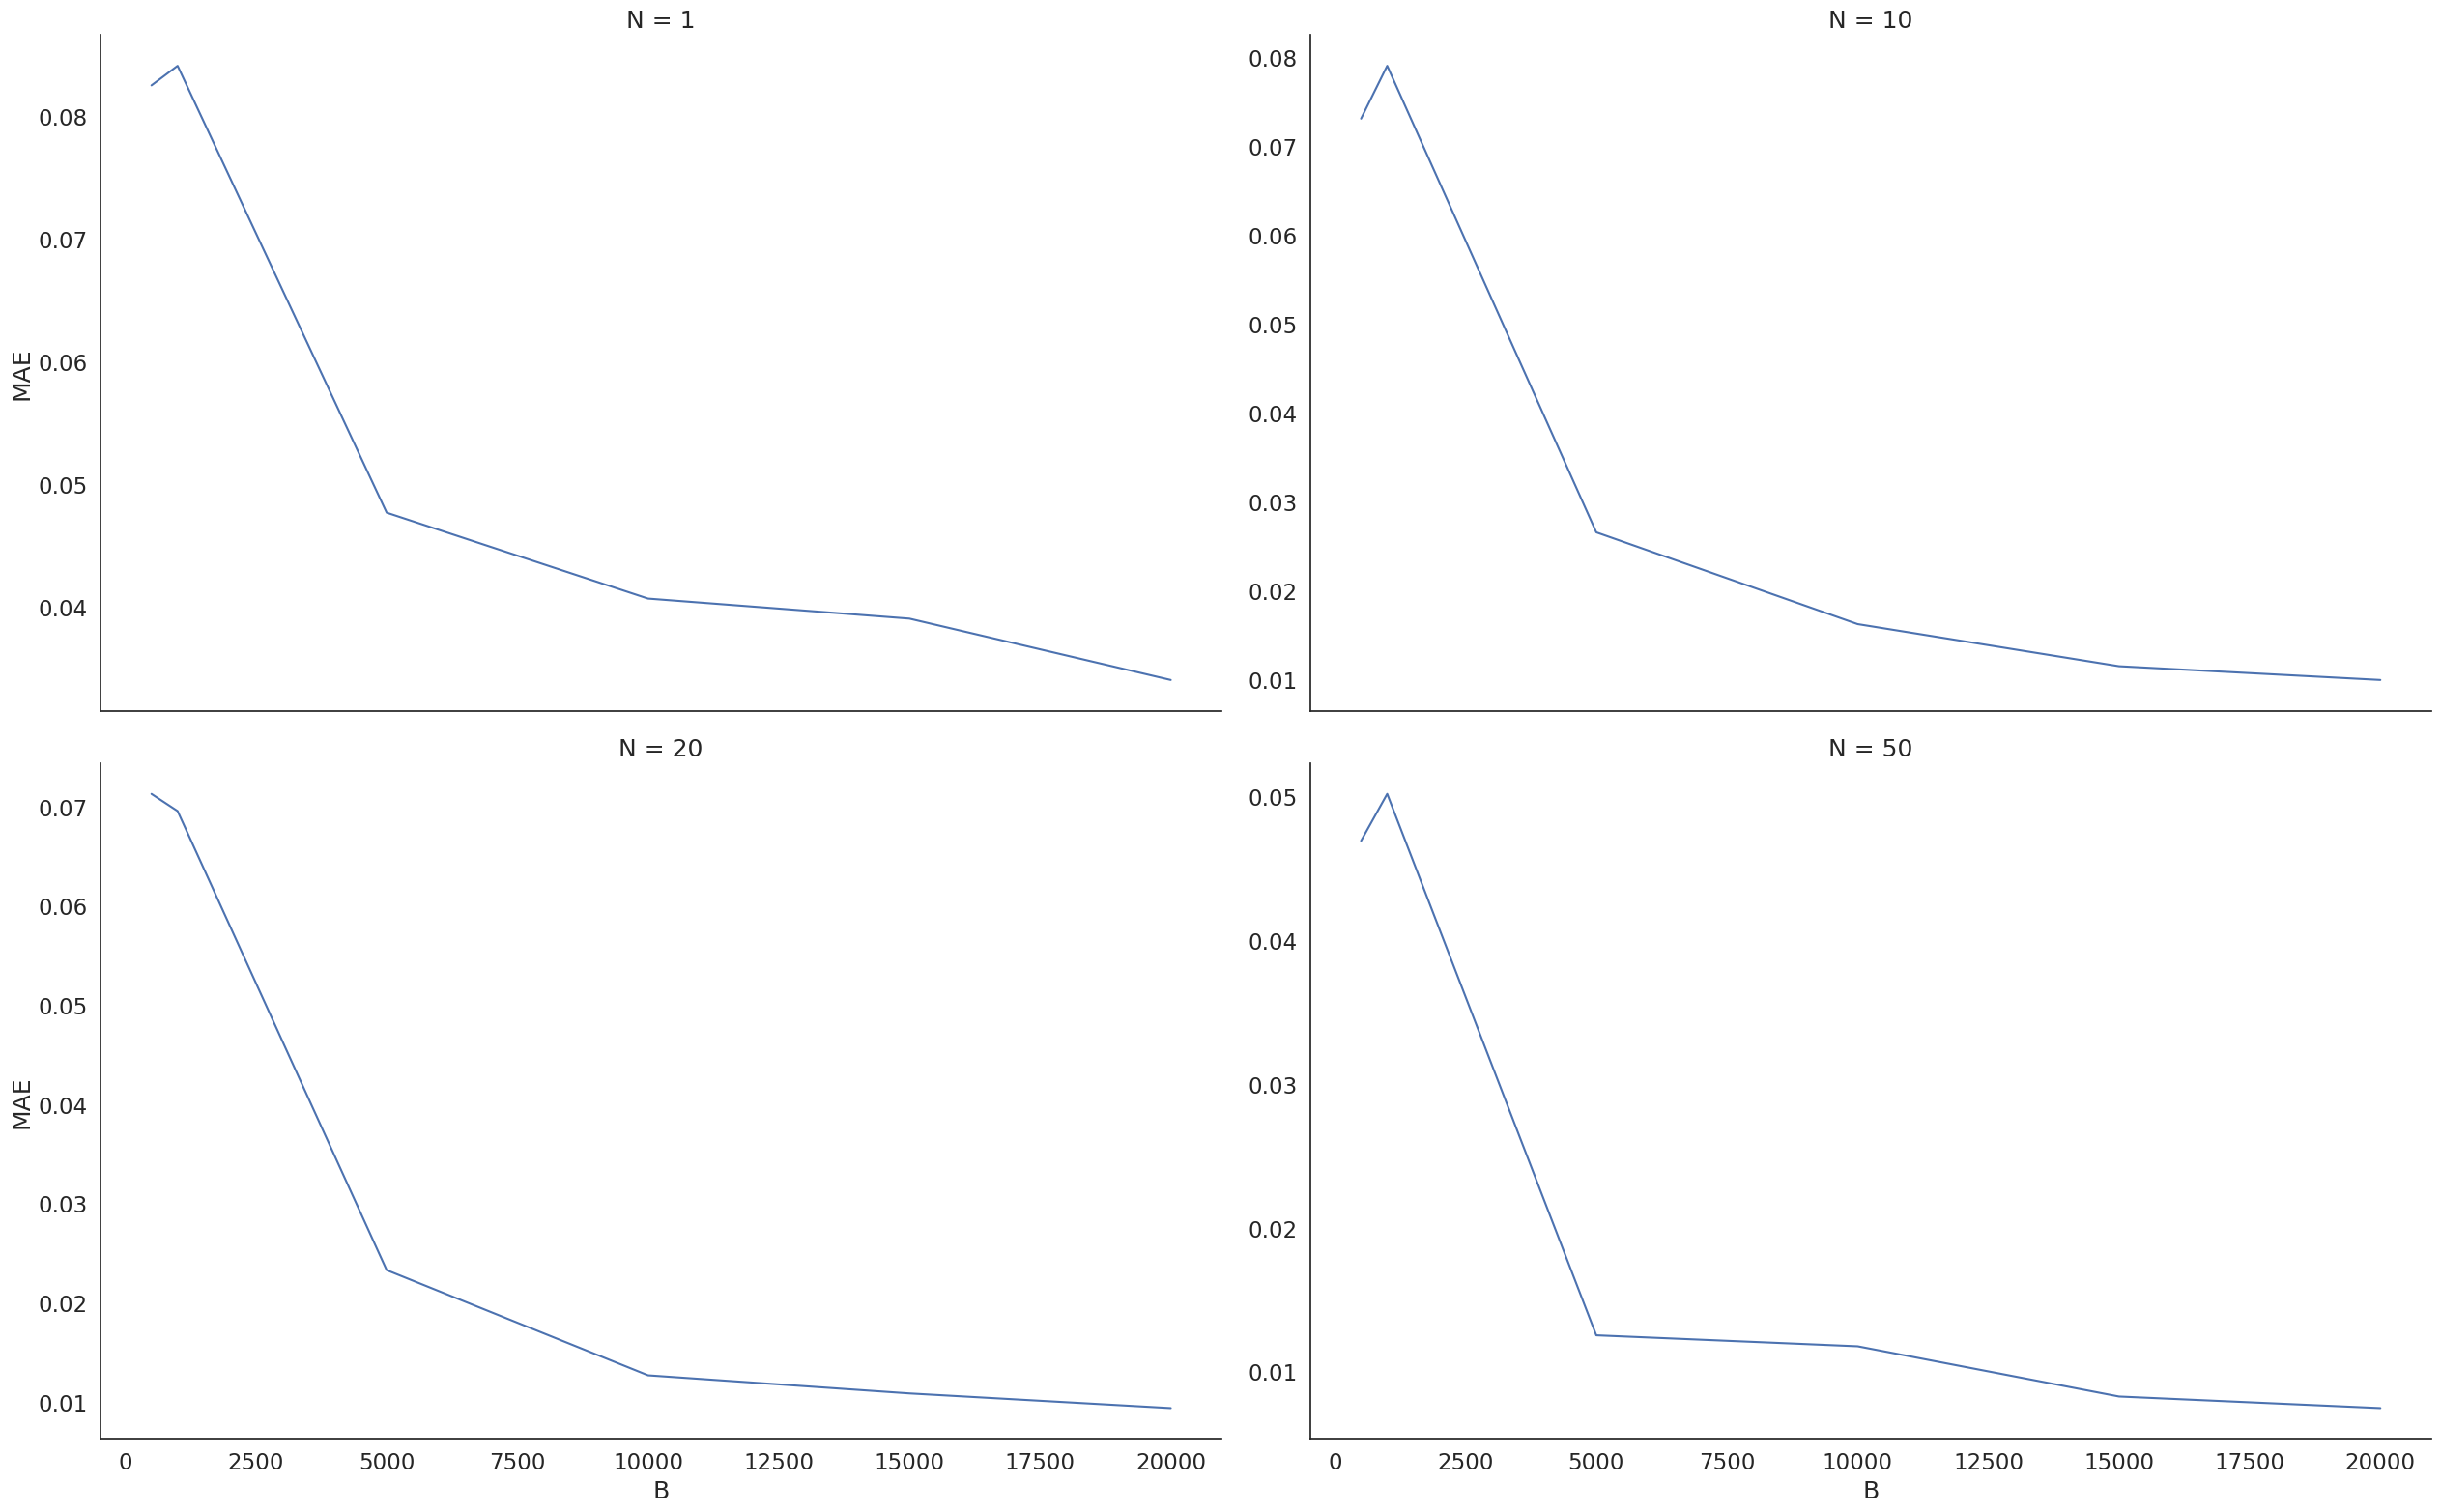

In [11]:
palette = sns.color_palette(cc.glasbey, n_colors=12)
sns.set(style="white", font_scale=1.5)
g = sns.FacetGrid(
    stats_df,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.60,
    palette=palette,
    margin_titles=True,
    sharey=False,
)

g.map(sns.lineplot, "B", "MAE")
plt.tight_layout()
plt.show()

Plotting the selected $K$ for comparisson:

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_116254/950250138.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


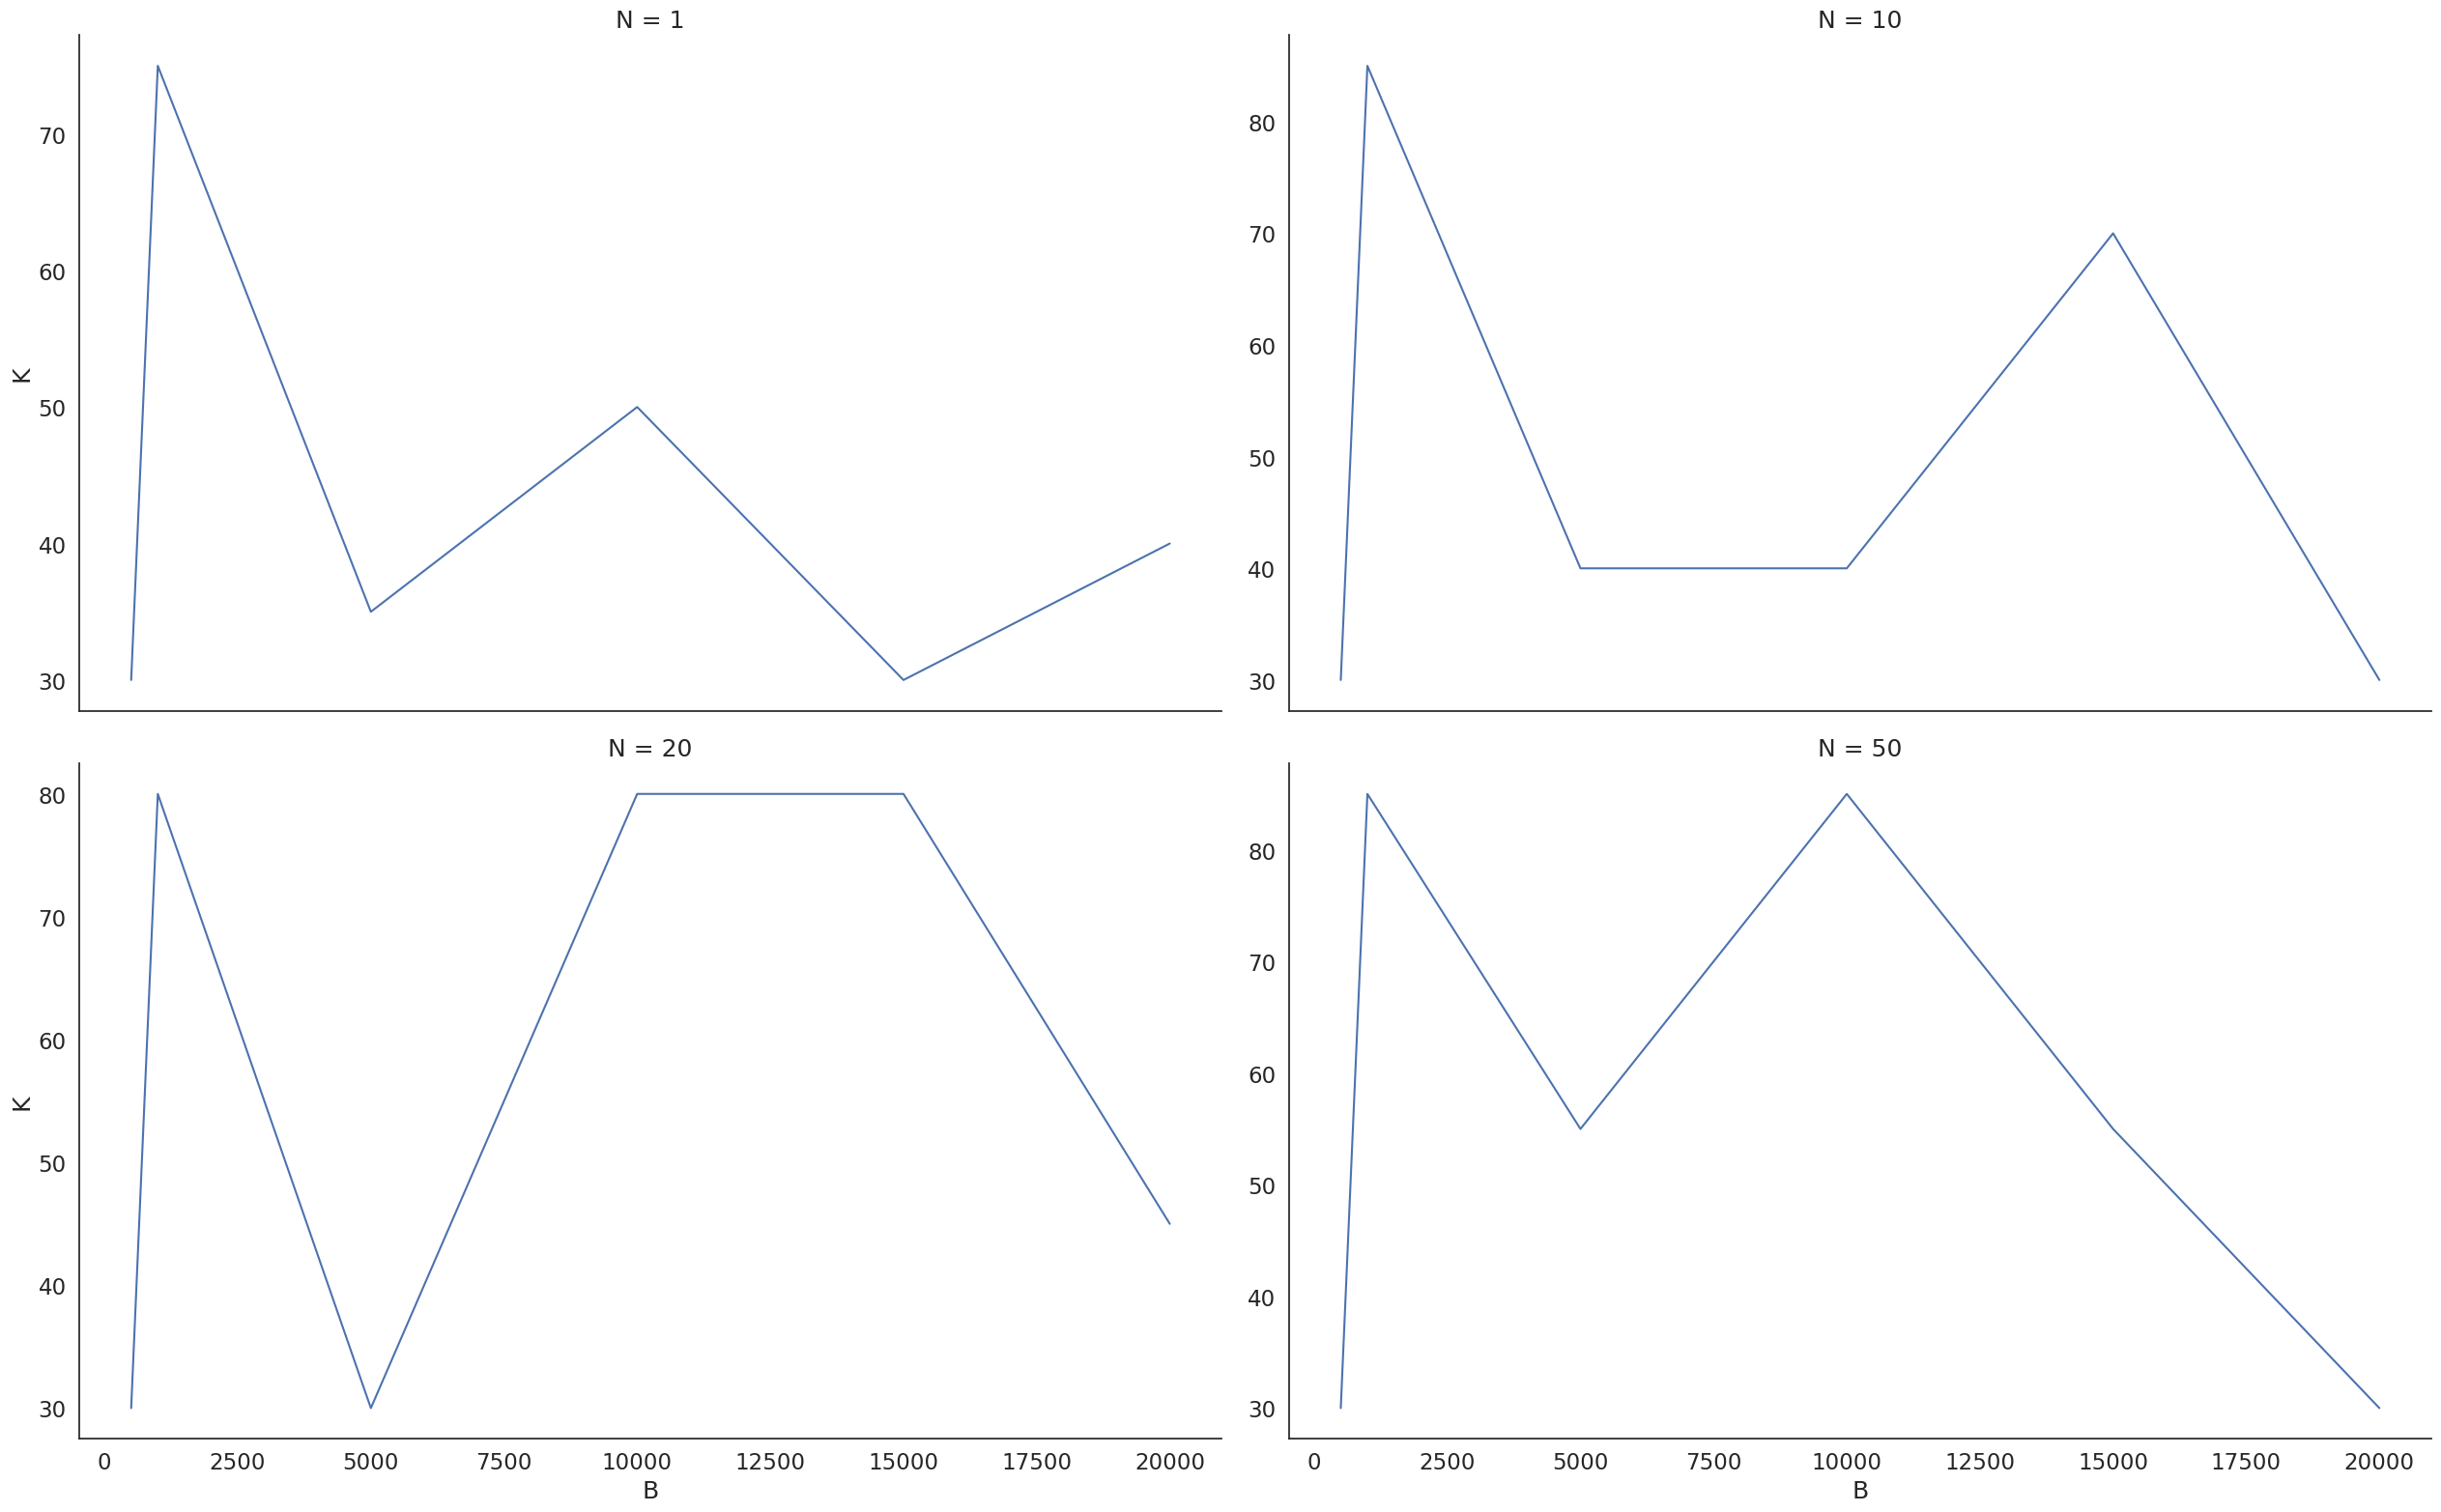

In [12]:
g = sns.FacetGrid(
    stats_df,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.60,
    palette=palette,
    margin_titles=True,
    sharey=False,
)

g.map(sns.lineplot, "B", "K")
plt.tight_layout()
plt.show()

## Exponential example

In [14]:
def sim_lambda(theta, rng, B = 1000, N = 100):
    lambdas = np.zeros(B)
    theoretical = np.e**(-theta)
    for k in range(0, B):
        exp = rng.exponential(1/theta, N)
        empirical = len([i for i in exp if i > 1])/len(exp)
        lambdas[k] = np.abs(theoretical - empirical)
    return lambdas

def train_naive(alpha, rng, B = 1000, N = 100, naive_n = 500, lower = 0.0001, upper = 6.9999):
    # simulating by a fixed theta_grid with size compatible with the amount of samples 
    # we want to simulate
    n_grid = int(B / naive_n)
    if n_grid > 1:
        step = (upper - lower)/n_grid
        thetas_fixed = np.arange(lower, upper, step)
    else:
        step = (upper - lower)/2
        thetas_fixed = np.array([np.arange(lower, upper, step)[1]])
      
    thetas_fixed = np.linspace(lower, upper, n_grid)
    
    quantiles = {}
    for theta in thetas_fixed:
        diff = sim_lambda(theta, B = n_grid, N = N, rng = rng)
        quantiles[theta] = np.quantile(diff, q = 1 - alpha)
    return quantiles

def predict_naive_quantile(theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for theta in theta_grid:
        idx = thetas_values[int(np.argmin(np.abs(theta - thetas_values)))]
        quantiles_list.append(quantiles_dict[idx])
    return quantiles_list
  
def generate_parameters_random(rng, B = 5000, N = 1000):
    random_theta_grid = rng.uniform(0, 7, B)
    lambdas = np.zeros(B)
    i = 0
    for theta in random_theta_grid:
        theoretical = np.e**(-theta)
        exp = rng.exponential(1/theta, N)
        empirical = (len([i for i in exp if i > 1])/len(exp))
        lambdas[i] = np.abs(theoretical - empirical)
        i += 1
    return random_theta_grid, lambdas

def obtain_quantiles(
    thetas,
    N,
    rng,
    B=1000,
    alpha=0.05,
    min_samples_leaf=300,
    K = 50,
    B_valid = 1000,
    N_lambda = 500,
    K_grid = np.arange(30, 85, 5),  
):
    # simulating to fit models
    theta_sim, model_lambdas = generate_parameters_random(B = B, rng = rng, N = N)
    model_thetas = theta_sim.reshape(-1, 1)

    # loforest quantiles
    start_time = time.time()
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False, tune_K = False
    )
    loforest_object.calibrate(
        model_thetas, model_lambdas, min_samples_leaf=min_samples_leaf, K=K, n_estimators=200
    )

    theta_valid, _ = generate_parameters_random(B=B_valid, N=N, rng=rng, )
    model_thetas_valid = theta_valid.reshape(-1, 1)
    lambda_valid = np.zeros((theta_valid.shape[0],N_lambda))
    i = 0
    for theta in theta_valid:
        lambda_valid[i, :] = sim_lambda(B = N_lambda, N = N, theta = theta, rng = rng)
        i += 1
    
    
    start_tune = time.time()
    # tuning K using validation set
    K_loforest = tune_loforest_LFI(loforest_object, model_thetas_valid, lambda_valid, K_grid = K_grid)
    end_tune = time.time()

    running_tune = end_tune - start_tune
    print(f"Tuning took {running_tune} seconds to run for N = {N} and B = {B}.")
    

    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1), K = K_loforest)
    end_time = time.time()

    running_time = end_time - start_time
    print(f"Loforest took {running_time} seconds to run.")
        
    quantile_dict = {
        "loforest_tuned" : loforest_cutoffs,
    }

    return quantile_dict, K_loforest

In [15]:
def evaluate_coverage_N_tuned_loforest(
        seed = 45,
        n_out = 500,
        n = 1000,
        N = np.array([5, 10, 20, 50]), 
        B = np.array([500, 1000, 5000, 10000, 15000, 20000]), 
        alpha = 0.05,
        min_samples_leaf=300, 
        K=50,
        K_grid = np.arange(30, 85, 5),
        B_valid = 1000,
        N_lambda = 750,
        ):
    
    rng = np.random.default_rng(seed)
    # generate testing grid
    thetas = np.linspace(0.0001, 6.9999, n_out)
    N_list = []
    mae_list = []
    se_list = []
    B_list = []
    K_list = []

    for N_fixed in N:
        for B_fixed in B:
            # Obtain the quantiles
            quantiles_dict, K_loforest = obtain_quantiles(
                thetas, 
                N_fixed, 
                rng, 
                B=B_fixed, 
                alpha=alpha, 
                min_samples_leaf=min_samples_leaf, 
                K=K,
                K_grid = K_grid,
                B_valid = B_valid,
                N_lambda = N_lambda,
                )
            
            err_data = np.zeros((thetas.shape[0], 1))
            
            print("tuned K = {}".format(K_loforest))

            # Check if the true lambda values fall within the predicted quantiles
            i = 0
            for theta in thetas:
                lambda_stat = sim_lambda(
                    B=n,
                    N=N_fixed,
                    theta=theta,
                    rng = rng,
                    )
                
                coverage = np.mean(lambda_stat <= quantiles_dict["loforest_tuned"][i])

                err_data[i, :] = np.array([np.abs(coverage - (1 - alpha))])
                i += 1
                
            K_list.extend([K_loforest])
            mae_list.extend(np.mean(err_data, axis=0).tolist())
            se_list.extend((np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))).tolist())
            N_list.extend([N_fixed])
            B_list.extend([B_fixed])
    
   
    stats_data = pd.DataFrame(
        {
            "K": K_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

In [21]:
start_time = time.time()
stats_df = evaluate_coverage_N_tuned_loforest(B = np.array([1000, 5000, 10000, 15000]),
                                              N = np.array([5, 10, 20, 50]),  
                                              n_out = 500, 
                                              n = 1000, 
                                              min_samples_leaf = 300, 
                                              K = 50, 
                                              K_grid = np.arange(30, 90, 5), 
                                              B_valid = 1000,
                                              )
end_time = time.time()

running_time = end_time - start_time
print(f"The simulation took {running_time} seconds to run.")

Tuning took 1.035240888595581 seconds to run for N = 5 and B = 1000.
Loforest took 2.9501566886901855 seconds to run.
tuned K = 30
Tuning took 1.850480556488037 seconds to run for N = 5 and B = 5000.
Loforest took 4.231947898864746 seconds to run.
tuned K = 55
Tuning took 2.5573573112487793 seconds to run for N = 5 and B = 10000.
Loforest took 5.6069495677948 seconds to run.
tuned K = 70
Tuning took 3.4031190872192383 seconds to run for N = 5 and B = 15000.
Loforest took 7.222530364990234 seconds to run.
tuned K = 30
Tuning took 1.0581333637237549 seconds to run for N = 10 and B = 1000.
Loforest took 3.1659131050109863 seconds to run.
tuned K = 40
Tuning took 1.8012144565582275 seconds to run for N = 10 and B = 5000.
Loforest took 4.353367805480957 seconds to run.
tuned K = 50
Tuning took 2.5446600914001465 seconds to run for N = 10 and B = 10000.
Loforest took 5.7563111782073975 seconds to run.
tuned K = 70
Tuning took 3.3869383335113525 seconds to run for N = 10 and B = 15000.
Lofore

In [22]:
stats_df.head(5)

,K,N,B,MAE,se
0,30,5,1000,0.037724,0.001201
1,55,5,5000,0.030838,0.000898
2,70,5,10000,0.030688,0.001985
3,30,5,15000,0.028452,0.000656
4,40,10,1000,0.039722,0.001280


Plotting loss across $B$ and $N$:

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_116254/1101952012.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


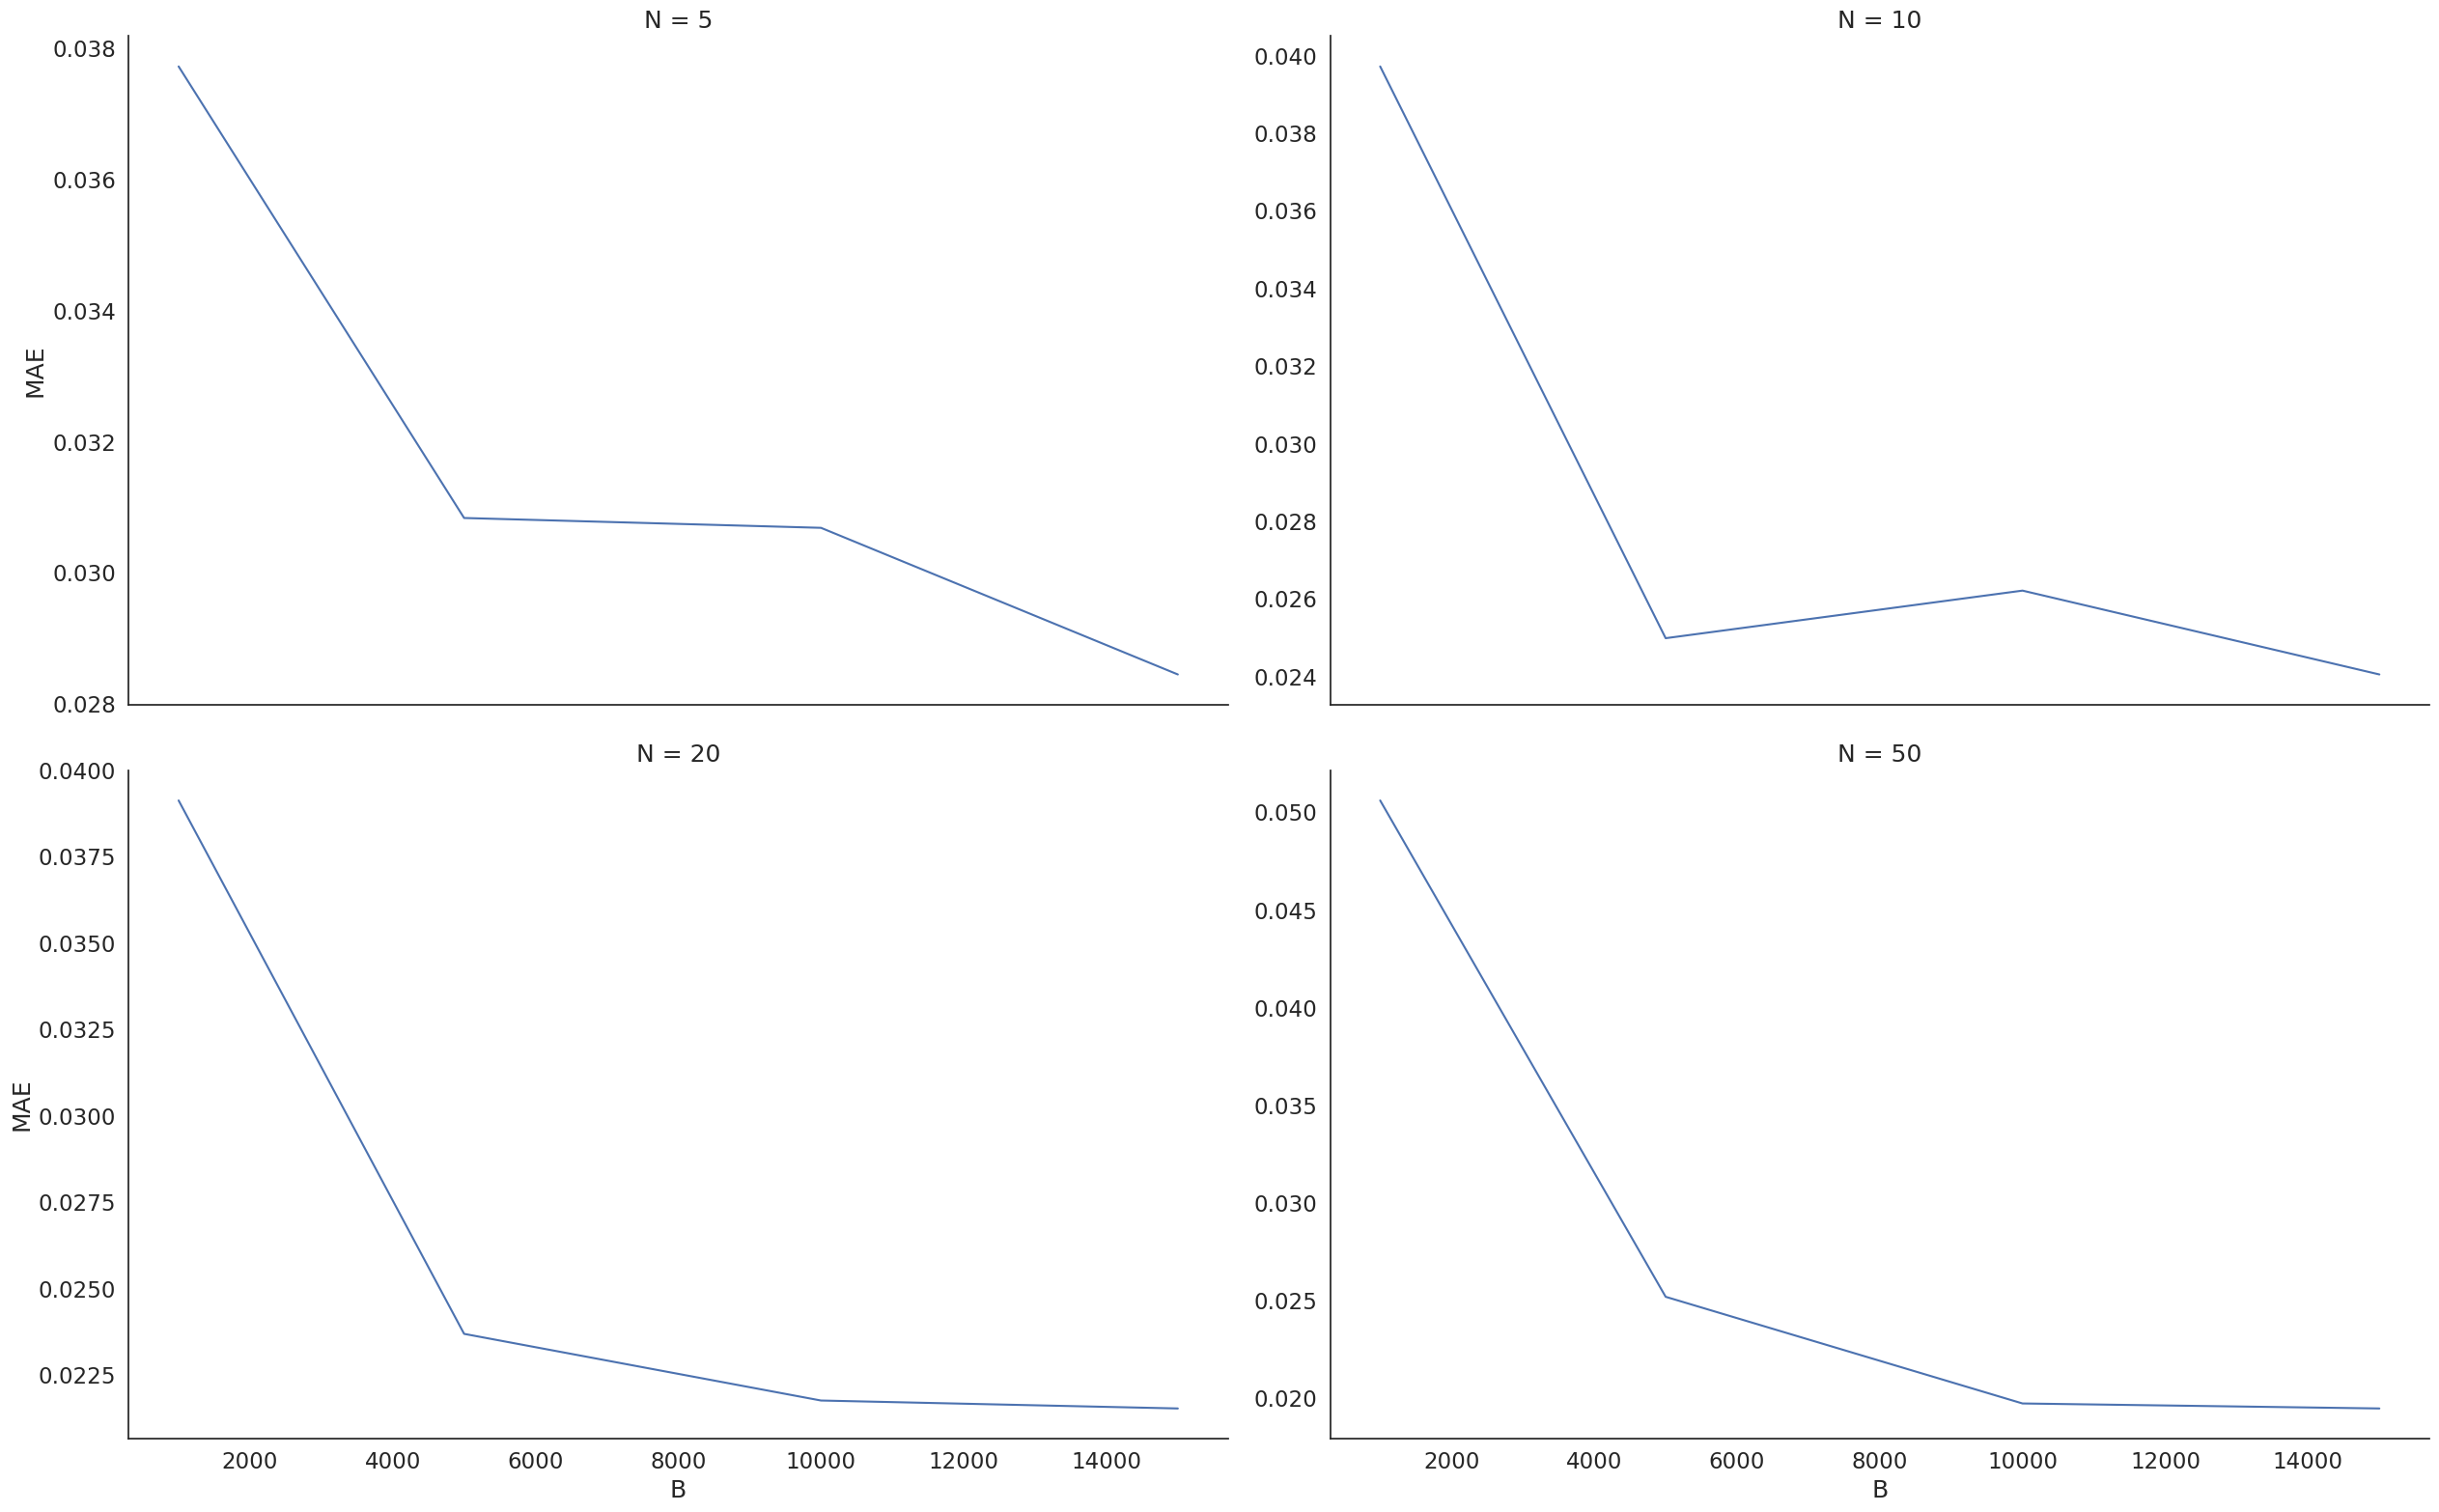

In [23]:
palette = sns.color_palette(cc.glasbey, n_colors=12)
sns.set(style="white", font_scale=1.5)
g = sns.FacetGrid(
    stats_df,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.60,
    palette=palette,
    margin_titles=True,
    sharey=False,
)

g.map(sns.lineplot, "B", "MAE")
plt.tight_layout()
plt.show()

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_116254/950250138.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


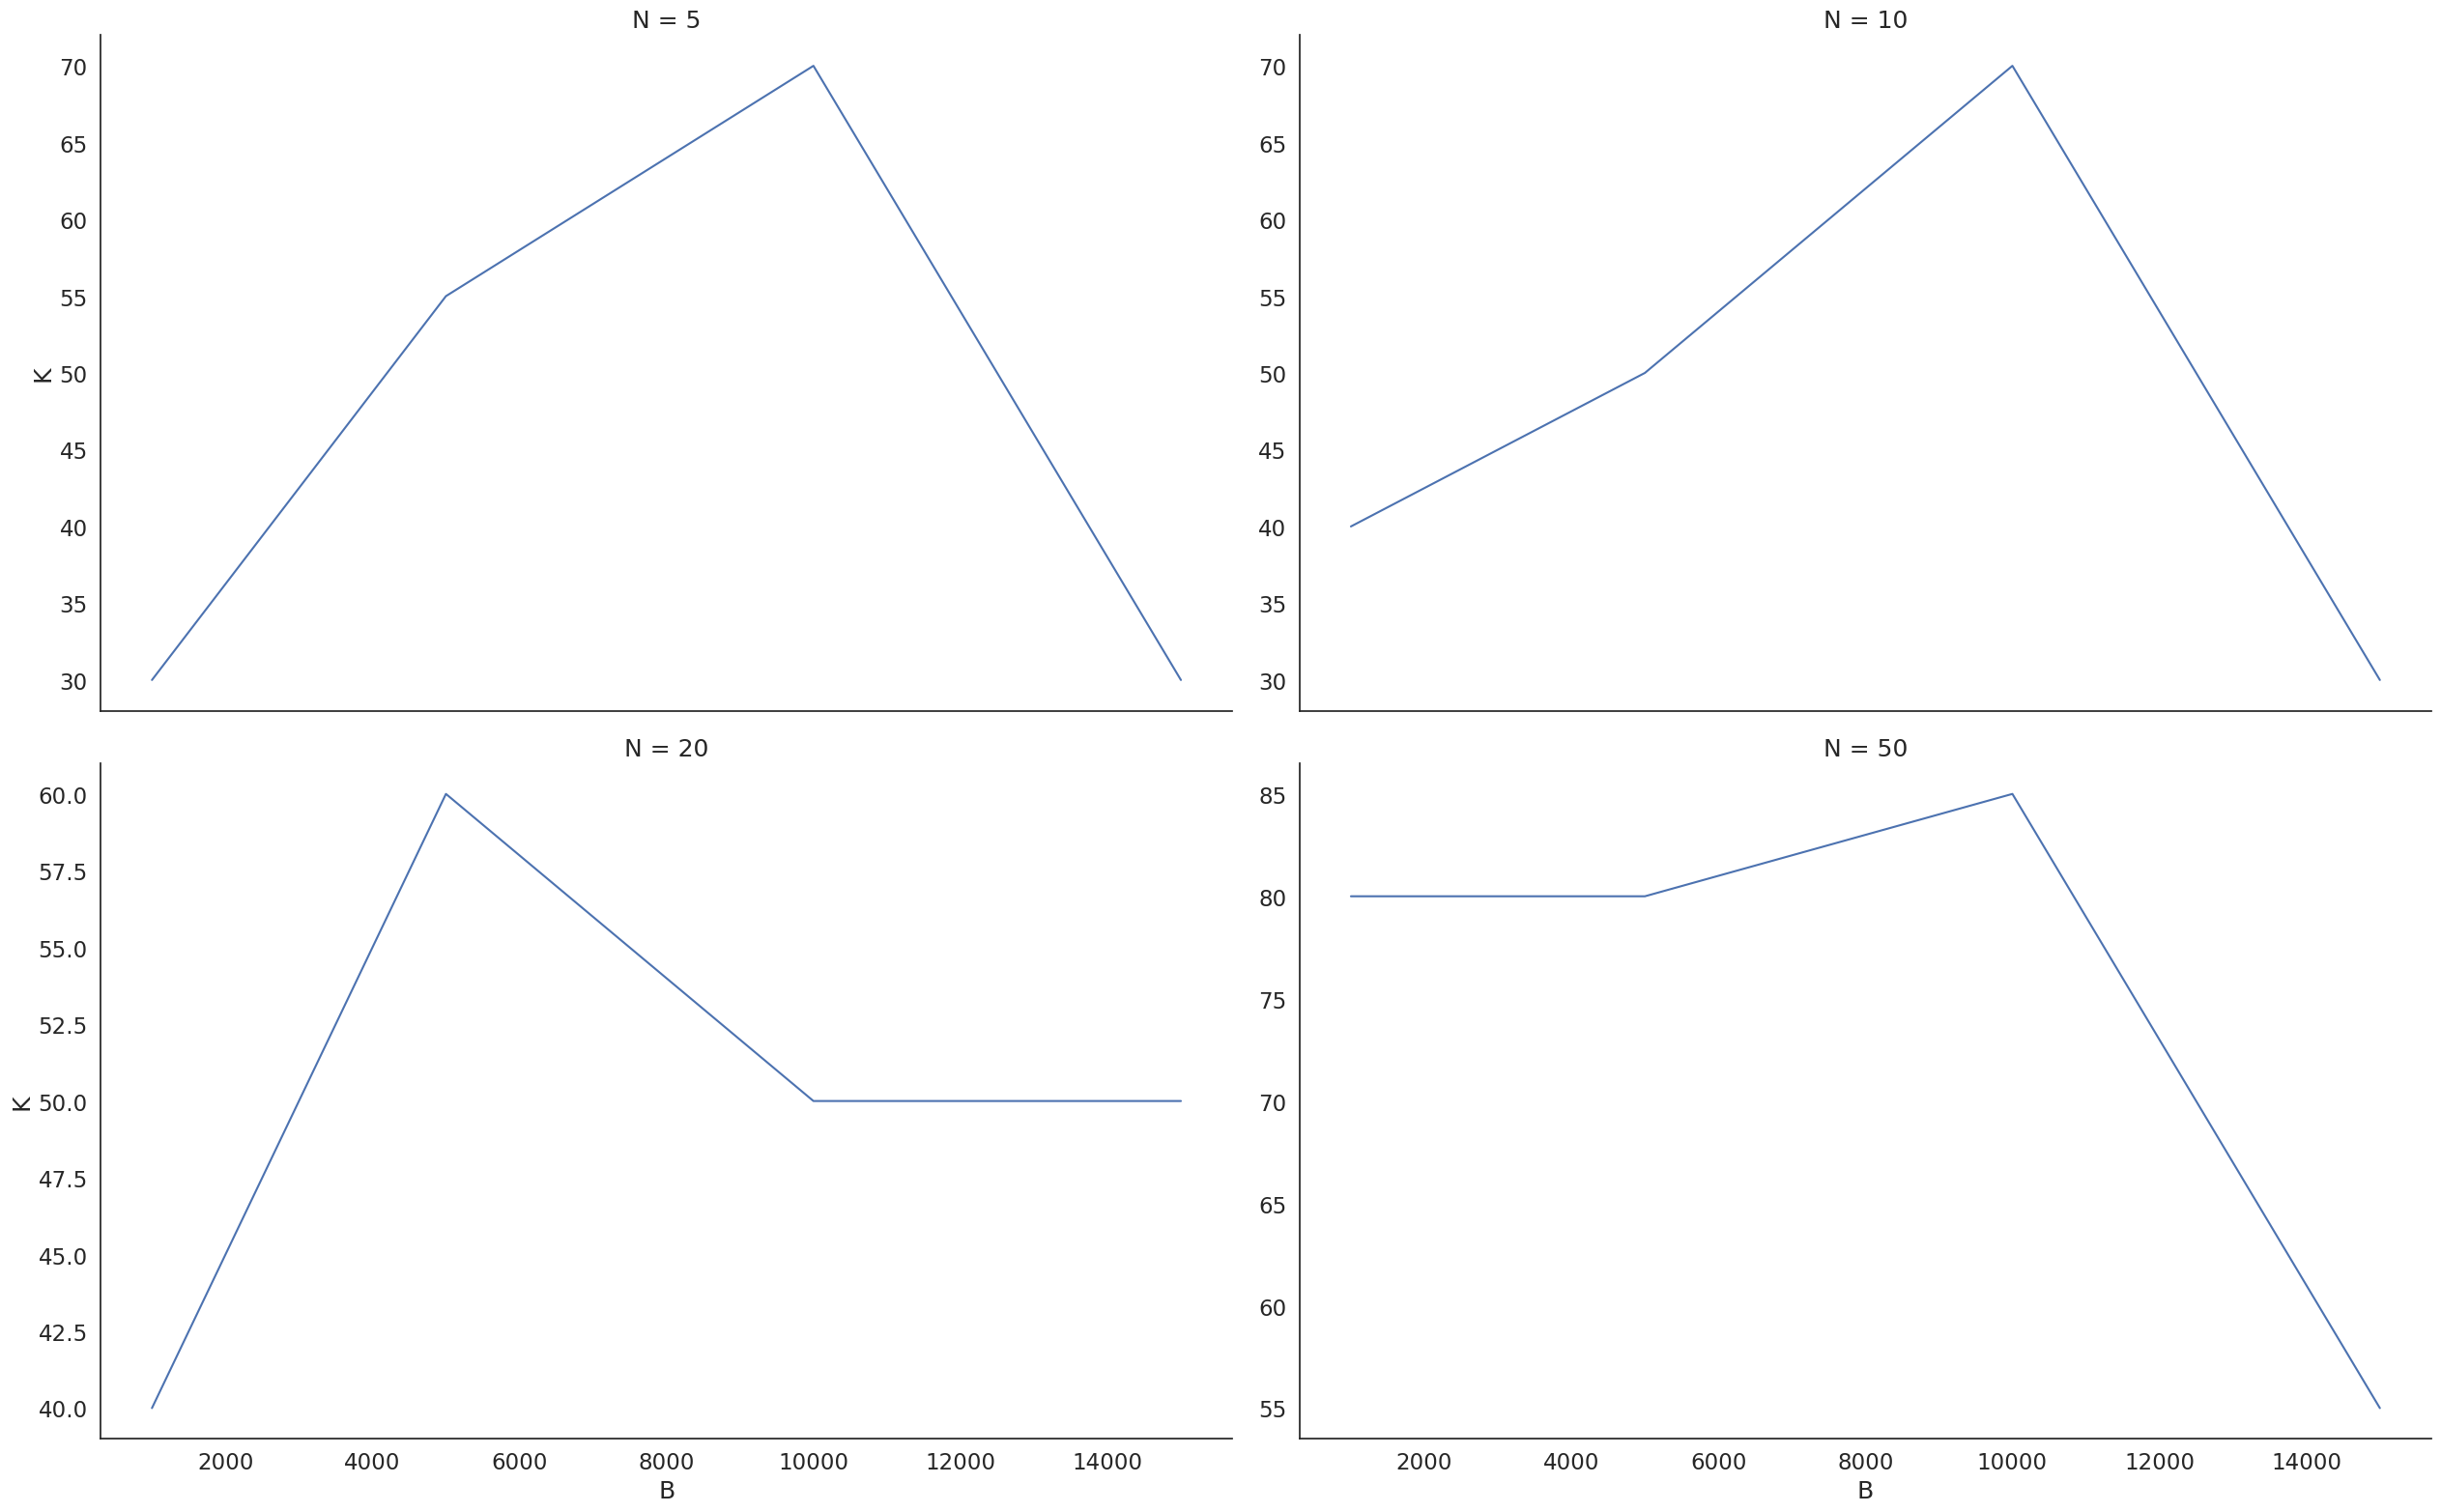

In [25]:
g = sns.FacetGrid(
    stats_df,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.60,
    palette=palette,
    margin_titles=True,
    sharey=False,
)

g.map(sns.lineplot, "B", "K")
plt.tight_layout()
plt.show()

## GMM example:

In [32]:
def sim_gmm(B, theta, rng):
    group = rng.binomial(n=1, p=0.5, size=B)
    X = ((group == 0) * (rng.normal(theta, 1, size=B))) + (
        (group == 1) * (rng.normal(-theta, 1, size=B))
    )
    return X

def sim_lambda(theta, rng, B=1000, N=100):
    lambdas = np.zeros(B)
    for i in range(0, B):
      X = sim_gmm(B = N, theta = theta, rng = rng)
      lambdas[i] = compute_lrt_statistic(theta, X)
    return lambdas


# randomly sampling from gmm
def sample_gmm(n, N, rng):
    thetas = rng.uniform(0, 5, size=n)
    lambdas = np.zeros(n)
    i = 0
    for theta in thetas:
        X = sim_gmm(B=N, theta=theta, rng=rng)
        lambdas[i] = compute_lrt_statistic(theta, X)
        i += 1
    return thetas, lambdas


# likelihood function
def l_func(theta, x):
    # prob from X
    p_x = np.log(
        (0.5 * stats.norm.pdf(x, loc=theta, scale=1))
        + (0.5 * stats.norm.pdf(x, loc=-theta, scale=1))
    )
    return -(np.sum(p_x))


# likelihood ratio statistic
def compute_lrt_statistic(theta_0, X, lower=0, upper=5):
    # computing MLE by grid
    res = minimize_scalar(
        l_func, args=(X), bounds=(lower, upper), tol=0.01, options={"maxiter": 100}
    )
    mle_theta = res.x
    lrt_stat = -2 * ((-l_func(theta_0, X)) - (-l_func(mle_theta, X)))
    return lrt_stat
  
# function to obtain all quantiles for a given B, sample size N and theta grid
def obtain_quantiles(
    thetas,
    N,
    rng,
    B=1000,
    alpha=0.05,
    min_samples_leaf=100,
    K=50,
    B_valid = 1000,
    N_lambda = 500,
    K_grid = np.arange(30, 85, 5),  
):
  
    # simulating to fit loforest
    theta_sim, model_lambdas = sample_gmm(n=B, N=N, rng=rng)
    model_thetas = theta_sim.reshape(-1, 1)

    # loforest quantiles
    start_time = time.time()
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False, tune_K = False
    )
    loforest_object.calibrate(
        model_thetas, model_lambdas, min_samples_leaf=min_samples_leaf, K=K, n_estimators=200
    )

    theta_valid, _ = sample_gmm(n = B_valid, N=N, rng=rng,)
    model_thetas_valid = theta_valid.reshape(-1, 1)
    lambda_valid = np.zeros((theta_valid.shape[0],N_lambda))
    i = 0
    for theta in theta_valid:
        lambda_valid[i, :] = sim_lambda(B = N_lambda, N = N, theta = theta, rng = rng)
        i += 1
    
    
    start_tune = time.time()
    # tuning K using validation set
    K_loforest = tune_loforest_LFI(loforest_object, model_thetas_valid, lambda_valid, K_grid = K_grid)
    end_tune = time.time()

    running_tune = end_tune - start_tune
    print(f"Tuning took {running_tune} seconds to run for N = {N} and B = {B}.")
    

    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1), K = K_loforest)
    end_time = time.time()

    running_time = end_time - start_time
    print(f"Loforest took {running_time} seconds to run.")
        
    quantile_dict = {
        "loforest_tuned" : loforest_cutoffs,
    }

    return quantile_dict, K_loforest 

In [33]:
def evaluate_coverage_N_tuned_loforest(
        seed = 45,
        n_out = 500,
        n = 1000,
        N = np.array([5, 10, 20, 50]), 
        B = np.array([500, 1000, 5000, 10000, 15000, 20000]), 
        alpha = 0.05,
        min_samples_leaf=300, 
        K=50,
        K_grid = np.arange(30, 85, 5),
        B_valid = 1000,
        N_lambda = 750,
        ):
    
    rng = np.random.default_rng(seed)
    # generate testing grid
    thetas = np.linspace(0.001, 4.999, n_out)
    N_list = []
    mae_list = []
    se_list = []
    B_list = []
    K_list = []

    for N_fixed in N:
        for B_fixed in B:
            # Obtain the quantiles
            quantiles_dict, K_loforest = obtain_quantiles(
                thetas, 
                N_fixed, 
                rng, 
                B=B_fixed, 
                alpha=alpha, 
                min_samples_leaf=min_samples_leaf, 
                K=K,
                K_grid = K_grid,
                B_valid = B_valid,
                N_lambda = N_lambda,
                )
            
            err_data = np.zeros((thetas.shape[0], 1))
            
            print("tuned K = {}".format(K_loforest))

            # Check if the true lambda values fall within the predicted quantiles
            i = 0
            for theta in thetas:
                lambda_stat = sim_lambda(
                    B=n,
                    N=N_fixed,
                    theta=theta,
                    rng = rng,
                    )
                
                coverage = np.mean(lambda_stat <= quantiles_dict["loforest_tuned"][i])

                err_data[i, :] = np.array([np.abs(coverage - (1 - alpha))])
                i += 1
                
            K_list.extend([K_loforest])
            mae_list.extend(np.mean(err_data, axis=0).tolist())
            se_list.extend((np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))).tolist())
            N_list.extend([N_fixed])
            B_list.extend([B_fixed])
    
   
    stats_data = pd.DataFrame(
        {
            "K": K_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

In [34]:
start_time = time.time()
stats_df = evaluate_coverage_N_tuned_loforest(B = np.array([1000, 5000, 10000, 15000]),
                                              N = np.array([1, 10, 20, 50]),  
                                              n_out = 500, 
                                              n = 1000, 
                                              min_samples_leaf = 300, 
                                              K = 50, 
                                              K_grid = np.arange(30, 90, 5), 
                                              B_valid = 1000,
                                              N_lambda = 300,
                                              )
end_time = time.time()

running_time = end_time - start_time
print(f"The simulation took {running_time} seconds to run.")

/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 0.9986612796783447 seconds to run for N = 1 and B = 1000.
Loforest took 295.0378222465515 seconds to run.
tuned K = 40


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 1.6766917705535889 seconds to run for N = 1 and B = 5000.
Loforest took 275.62229561805725 seconds to run.
tuned K = 75


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 2.5655996799468994 seconds to run for N = 1 and B = 10000.
Loforest took 288.7649624347687 seconds to run.
tuned K = 60


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 3.1634256839752197 seconds to run for N = 1 and B = 15000.
Loforest took 285.70771622657776 seconds to run.
tuned K = 75


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 0.9625442028045654 seconds to run for N = 10 and B = 1000.
Loforest took 327.41500425338745 seconds to run.
tuned K = 85


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 1.6321017742156982 seconds to run for N = 10 and B = 5000.
Loforest took 324.41968035697937 seconds to run.
tuned K = 45


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 2.3217954635620117 seconds to run for N = 10 and B = 10000.
Loforest took 328.3475396633148 seconds to run.
tuned K = 40


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 3.084876537322998 seconds to run for N = 10 and B = 15000.
Loforest took 332.01310896873474 seconds to run.
tuned K = 65


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 0.949230432510376 seconds to run for N = 20 and B = 1000.
Loforest took 320.2192599773407 seconds to run.
tuned K = 30


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 1.604658603668213 seconds to run for N = 20 and B = 5000.
Loforest took 319.5927653312683 seconds to run.
tuned K = 30


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 2.4508488178253174 seconds to run for N = 20 and B = 10000.
Loforest took 336.5121772289276 seconds to run.
tuned K = 65


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 3.378082036972046 seconds to run for N = 20 and B = 15000.
Loforest took 351.2562737464905 seconds to run.
tuned K = 75


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 0.9777631759643555 seconds to run for N = 50 and B = 1000.
Loforest took 605.6871075630188 seconds to run.
tuned K = 30


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 1.8433513641357422 seconds to run for N = 50 and B = 5000.
Loforest took 343.8532872200012 seconds to run.
tuned K = 55


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 2.751492977142334 seconds to run for N = 50 and B = 10000.
Loforest took 346.1575105190277 seconds to run.
tuned K = 60


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


Tuning took 3.794745445251465 seconds to run for N = 50 and B = 15000.
Loforest took 354.52680253982544 seconds to run.
tuned K = 30


/home/kuben45/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


The simulation took 14070.212131738663 seconds to run.


In [35]:
stats_df.head(5)

,K,N,B,MAE,se
0,40,1,1000,0.025340,0.001260
1,75,1,5000,0.011334,0.000355
2,60,1,10000,0.009442,0.000310
3,75,1,15000,0.008308,0.000277
4,85,10,1000,0.015732,0.000447


/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_116254/1101952012.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


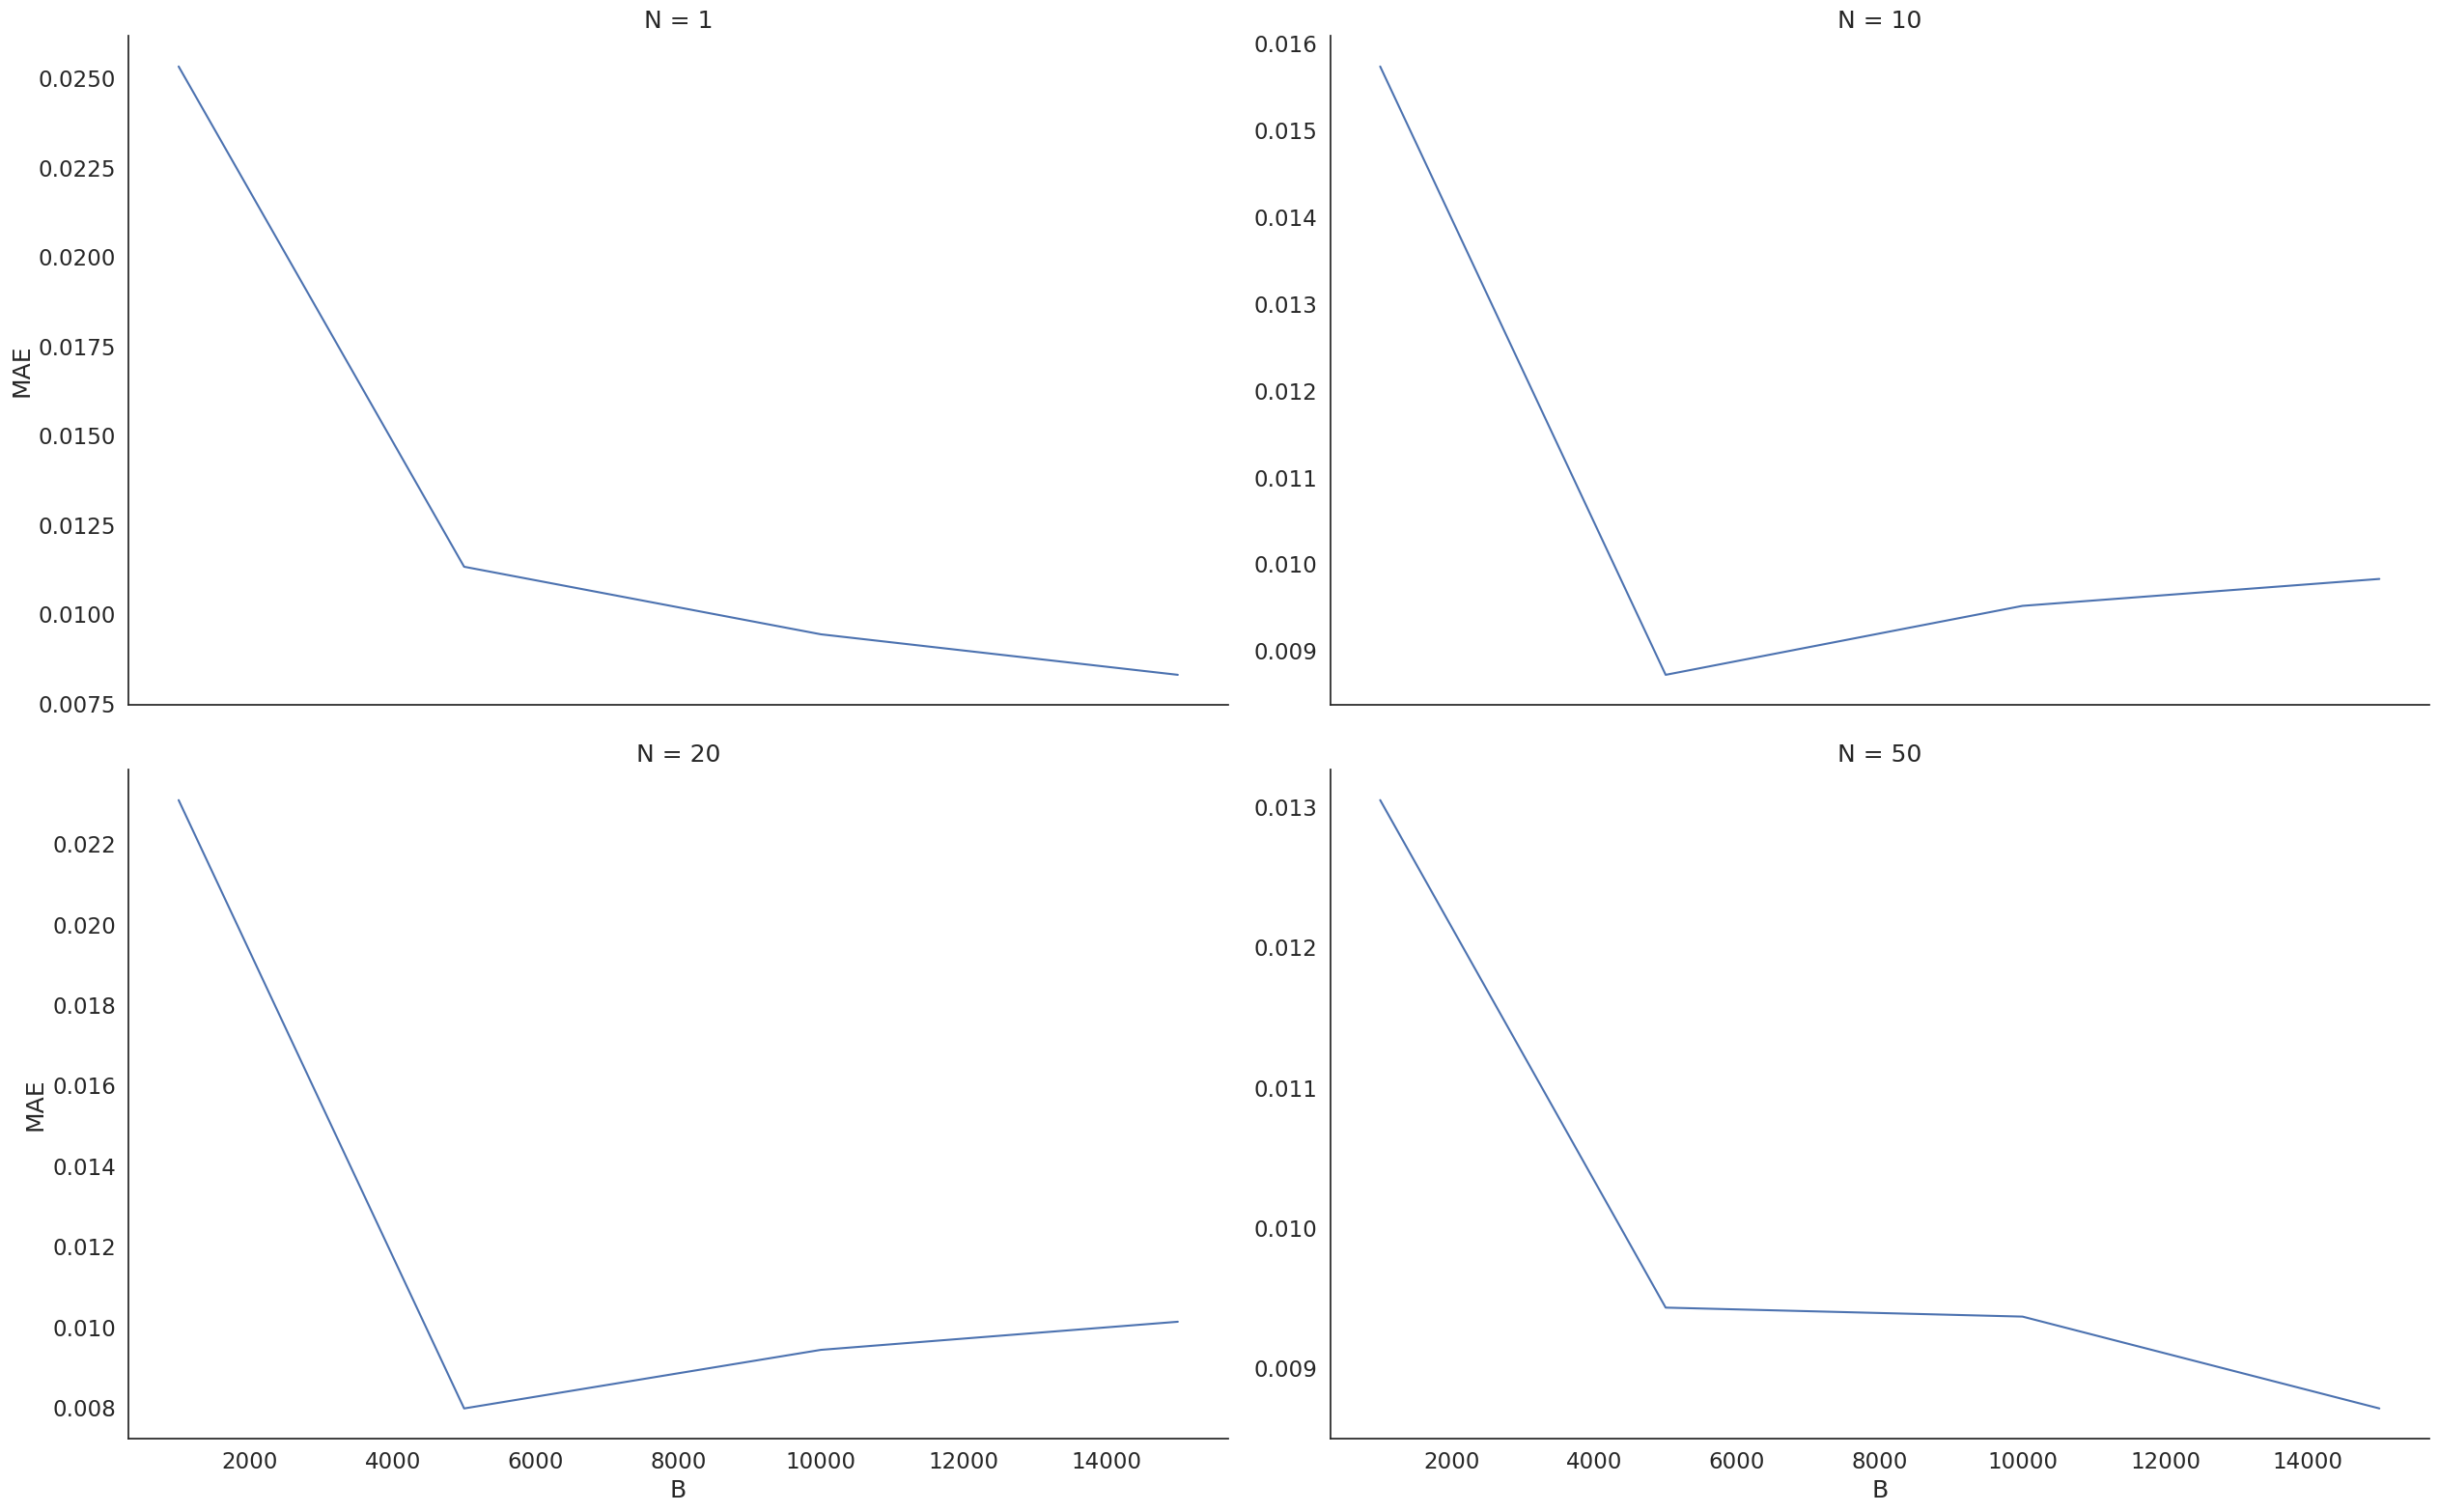

In [36]:
palette = sns.color_palette(cc.glasbey, n_colors=12)
sns.set(style="white", font_scale=1.5)
g = sns.FacetGrid(
    stats_df,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.60,
    palette=palette,
    margin_titles=True,
    sharey=False,
)

g.map(sns.lineplot, "B", "MAE")
plt.tight_layout()
plt.show()

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_116254/950250138.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


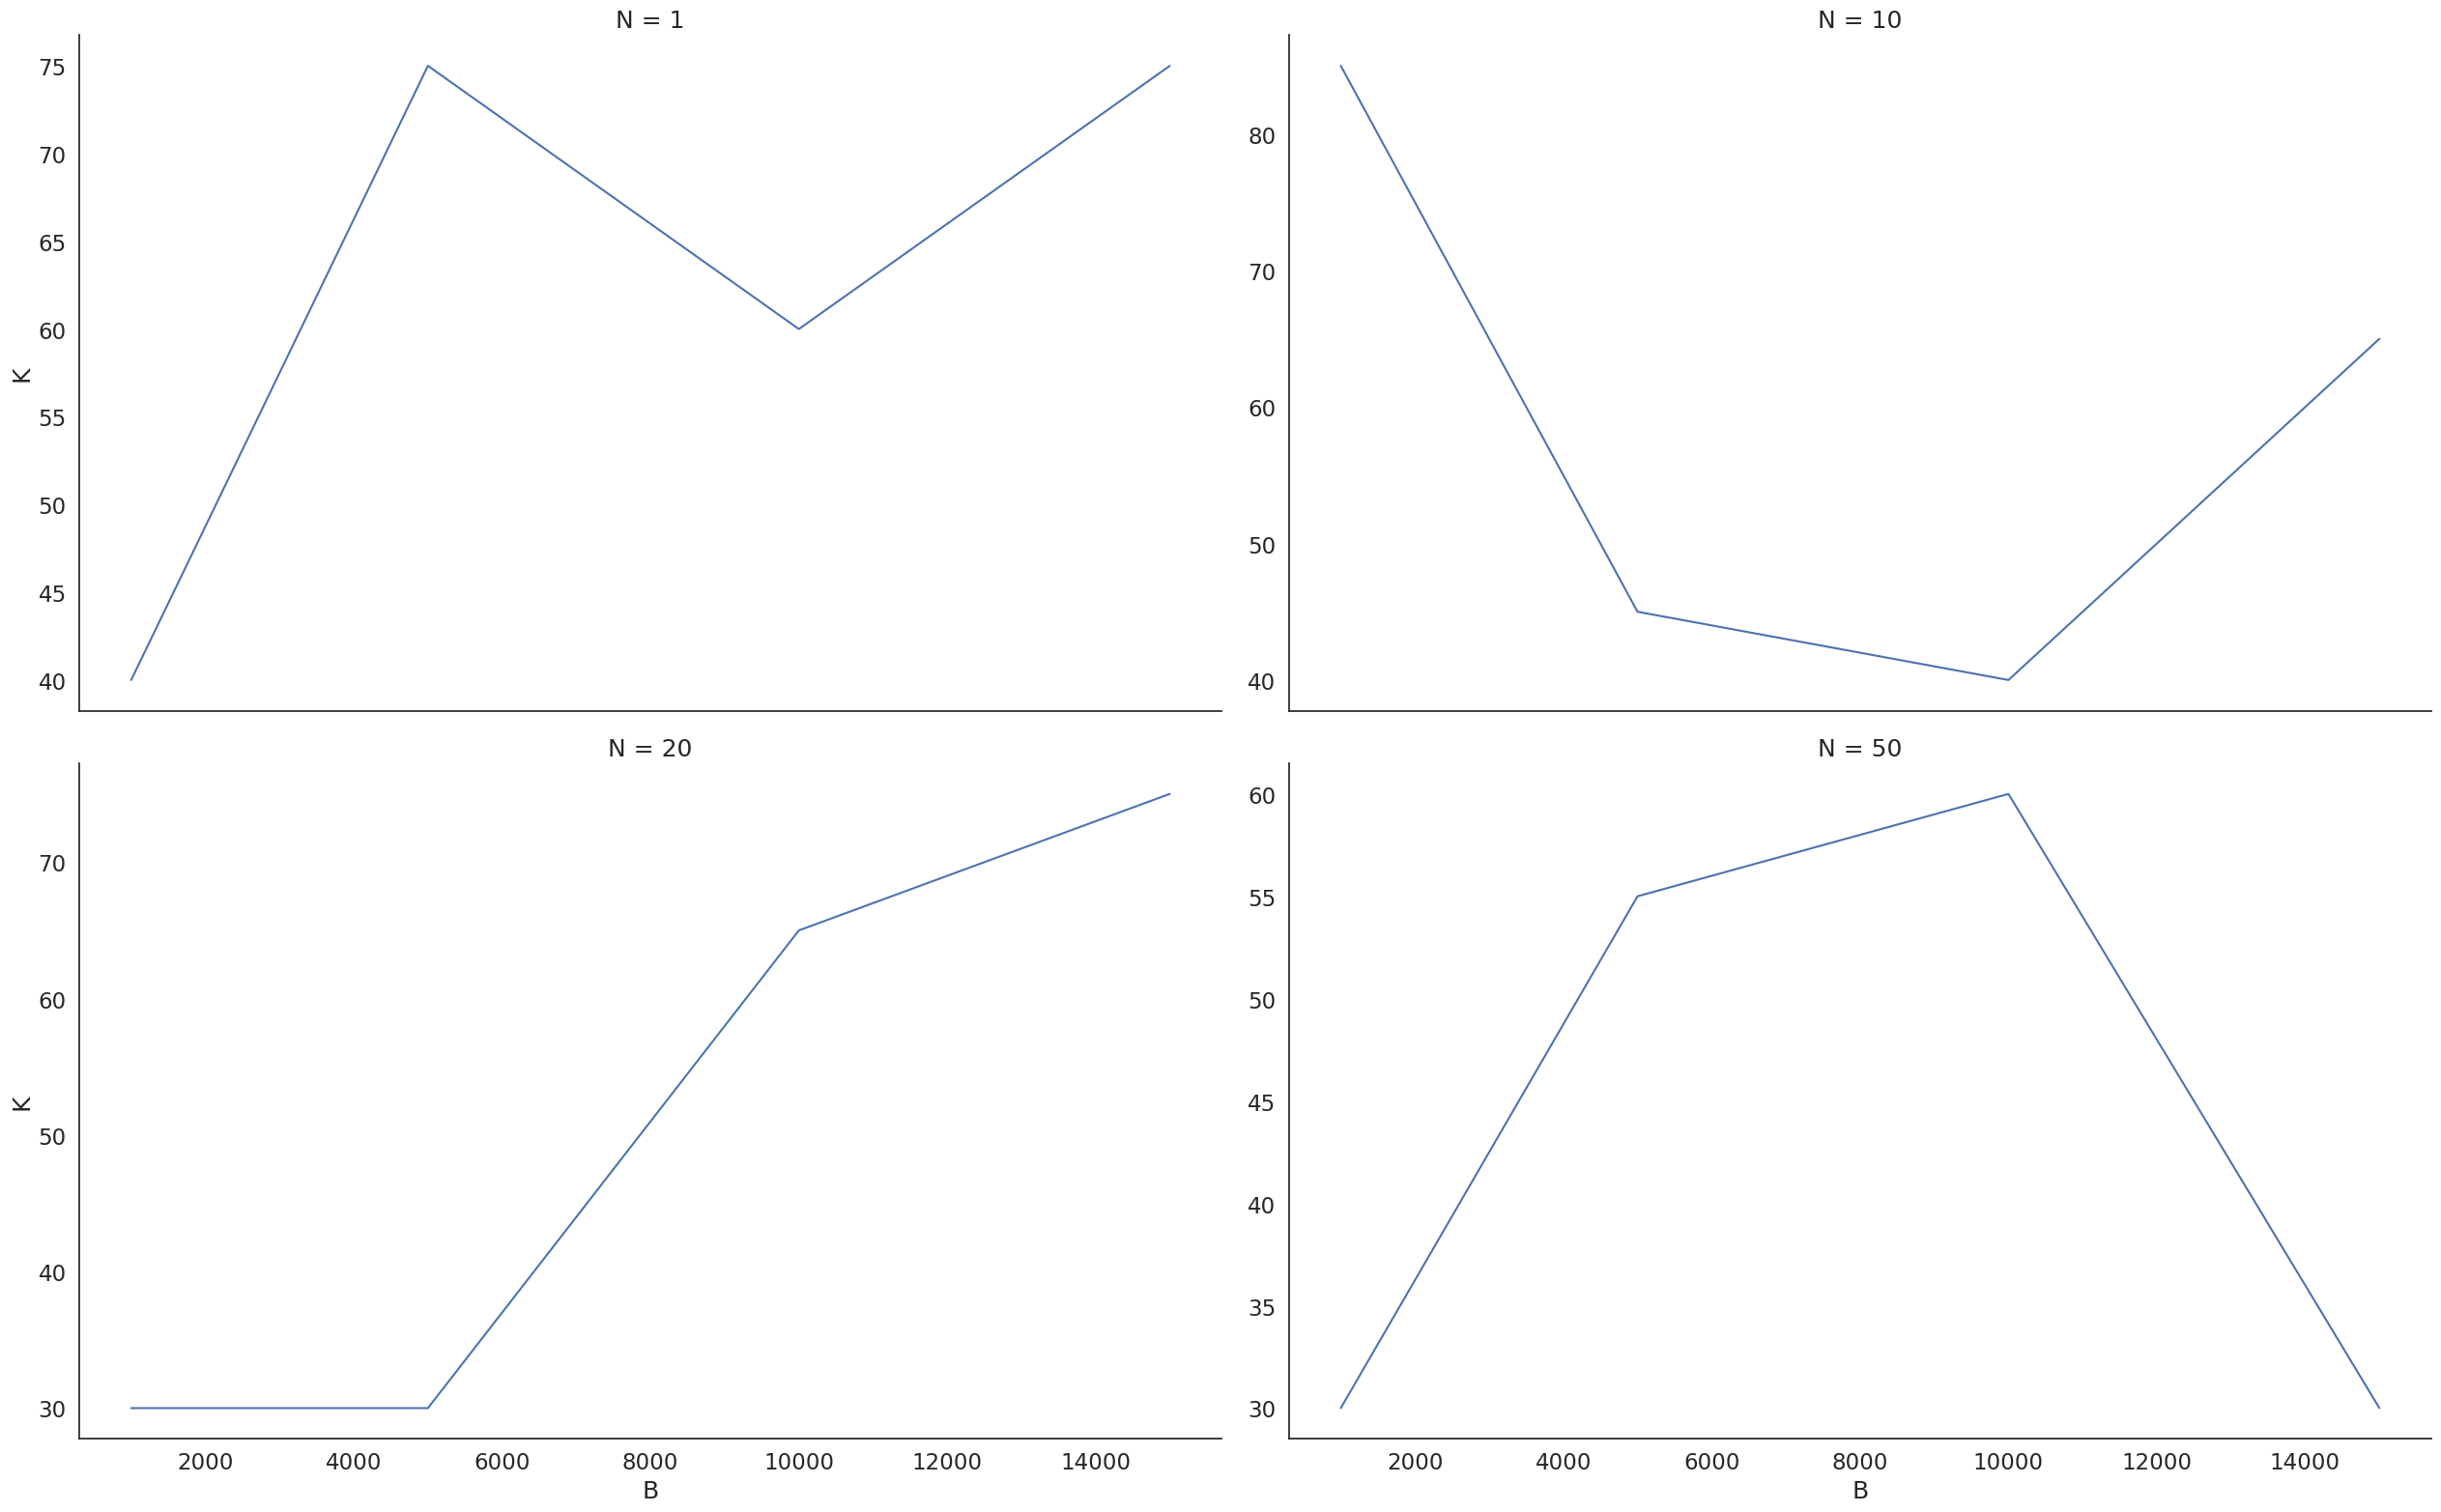

In [37]:
g = sns.FacetGrid(
    stats_df,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.60,
    palette=palette,
    margin_titles=True,
    sharey=False,
)

g.map(sns.lineplot, "B", "K")
plt.tight_layout()
plt.show()

## Gamma experiment

In [55]:
def sim_gamma(gamma_shape, gamma_scale, n, rng, threshold=None):
    
    random_x = rng.gamma(gamma_shape, gamma_scale, n)
    
    if not threshold:
        threshold = rng.choice(random_x)

    emp_prob = np.mean(random_x > threshold)
    t_prob = 1 - stats.gamma.cdf(threshold, a=gamma_shape, scale=gamma_scale)

    lambda_stat = np.abs(t_prob - emp_prob)

    return lambda_stat

# randomly sampling from gamma
def sample_gamma(n, N, rng, threshold=None):
    thetas = np.c_[rng.uniform(2, 8, n), rng.uniform(4, 10, n)]
    lambdas = np.zeros(n)
    i = 0
    for shape, scale in thetas:
        lambdas[i] = sim_gamma(gamma_shape=shape, 
                               gamma_scale=scale, 
                               n=N, 
                               rng=rng, 
                               threshold=threshold)
        i += 1
    return thetas, lambdas

def obtain_quantiles(
    thetas,
    N,
    rng,
    B=1000,
    alpha=0.05,
    min_samples_leaf=100,
    n_estimators=200,
    K=50,
    threshold=None,
    B_valid = 1000,
    N_lambda = 500,
    K_grid = np.arange(30, 85, 5),  
):

    # simulating to fit models
    thetas_sim, model_lambdas = sample_gamma(n=B, N=N, rng=rng, threshold=threshold)

    model_thetas = thetas_sim.reshape(-1, 2)

    # loforest quantiles
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    loforest_object.calibrate(
        model_thetas, 
        model_lambdas, 
        min_samples_leaf=min_samples_leaf, 
        n_estimators=n_estimators,
        K=K,
    )

    theta_valid, _ = sample_gamma(n = B_valid, N=N, rng=rng, threshold=threshold)
    model_thetas_valid = theta_valid.reshape(-1, 2)
    lambda_valid = np.zeros((theta_valid.shape[0],N_lambda))
    
    i = 0
    for theta in theta_valid:
        for j in range(0, N_lambda):
                    lambda_valid[i, j] = sim_gamma(
                        gamma_shape=theta[0], 
                        gamma_scale=theta[1], 
                        n=N, 
                        rng=rng,
                        threshold=threshold,
                    )
        i += 1
    
    
    start_tune = time.time()
    # tuning K using validation set
    K_loforest = tune_loforest_LFI(loforest_object, model_thetas_valid, lambda_valid, K_grid = K_grid)
    end_tune = time.time()

    running_tune = end_tune - start_tune
    print(f"Tuning took {running_tune} seconds to run for N = {N} and B = {B}.")
    

    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 2), K = K_loforest)
    end_time = time.time()

    running_time = end_time - start_time
    print(f"Loforest took {running_time} seconds to run.")
        
    quantile_dict = {
        "loforest_tuned" : loforest_cutoffs,
    }

    return quantile_dict, K_loforest

In [56]:
def evaluate_coverage_N_tuned_loforest(
        seed = 45,
        n_out = 50,
        n = 1000,
        N = np.array([5, 10, 20, 50]), 
        B = np.array([500, 1000, 5000, 10000, 15000, 20000]), 
        alpha = 0.05,
        min_samples_leaf=300, 
        K=50,
        K_grid = np.arange(30, 85, 5),
        B_valid = 1000,
        N_lambda = 750,
        threshold = 30,
        ):
    
    rng = np.random.default_rng(seed)
    # generate testing grid
    a_s = np.linspace(2.0001, 7.9999, n_out)
    b_s = np.linspace(4.0001, 9.9999, n_out)
    thetas = np.c_[list(itertools.product(a_s, b_s))]

    N_list = []
    mae_list = []
    se_list = []
    B_list = []
    K_list = []

    for N_fixed in N:
        for B_fixed in B:
            # Obtain the quantiles
            quantiles_dict, K_loforest = obtain_quantiles(
                thetas = thetas, 
                N = N_fixed, 
                rng = rng, 
                B=B_fixed, 
                alpha=alpha, 
                min_samples_leaf=min_samples_leaf, 
                K=K,
                K_grid = K_grid,
                B_valid = B_valid,
                N_lambda = N_lambda,
                threshold=threshold,
                )
            
            err_data = np.zeros((thetas.shape[0], 1))
            
            print("tuned K = {}".format(K_loforest))

            # Check if the true lambda values fall within the predicted quantiles
            i = 0
            for theta in thetas:
                lambda_stat = np.zeros(n)
                for j in range(0, n):
                    lambda_stat[j] = sim_gamma(
                        gamma_shape=theta[0], 
                        gamma_scale=theta[1], 
                        n=N_fixed, 
                        rng=rng,
                        threshold=threshold,
                    )
                
                coverage = np.mean(lambda_stat <= quantiles_dict["loforest_tuned"][i])

                err_data[i, :] = np.array([np.abs(coverage - (1 - alpha))])
                i += 1
                
            K_list.extend([K_loforest])
            mae_list.extend(np.mean(err_data, axis=0).tolist())
            se_list.extend((np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))).tolist())
            N_list.extend([N_fixed])
            B_list.extend([B_fixed])
    
   
    stats_data = pd.DataFrame(
        {
            "K": K_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

In [59]:
start_time = time.time()
stats_df = evaluate_coverage_N_tuned_loforest(B = np.array([1000, 5000, 10000, 15000]),
                                              N = np.array([5, 10, 20, 50]),  
                                              n_out = 50, 
                                              n = 1000, 
                                              min_samples_leaf = 300, 
                                              K = 50, 
                                              K_grid = np.arange(30, 90, 5), 
                                              B_valid = 1000,
                                              N_lambda = 750,
                                              threshold = 30,
                                            )
end_time = time.time()

running_time = end_time - start_time
print(f"The simulation took {running_time} seconds to run.")

Tuning took 1.0353219509124756 seconds to run for N = 5 and B = 1000.
Loforest took 50.01553416252136 seconds to run.
tuned K = 40
Tuning took 1.9057955741882324 seconds to run for N = 5 and B = 5000.
Loforest took 260.3046381473541 seconds to run.
tuned K = 60
Tuning took 4.648686170578003 seconds to run for N = 5 and B = 10000.
Loforest took 477.5378475189209 seconds to run.
tuned K = 65
Tuning took 4.303103923797607 seconds to run for N = 5 and B = 15000.
Loforest took 724.1686043739319 seconds to run.
tuned K = 65
Tuning took 1.1546738147735596 seconds to run for N = 10 and B = 1000.
Loforest took 958.0892622470856 seconds to run.
tuned K = 30
Tuning took 2.0999915599823 seconds to run for N = 10 and B = 5000.
Loforest took 1195.995750427246 seconds to run.
tuned K = 55
Tuning took 2.861131191253662 seconds to run for N = 10 and B = 10000.
Loforest took 1435.8393154144287 seconds to run.
tuned K = 60
Tuning took 3.9443483352661133 seconds to run for N = 10 and B = 15000.
Loforest t

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_116254/1101952012.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


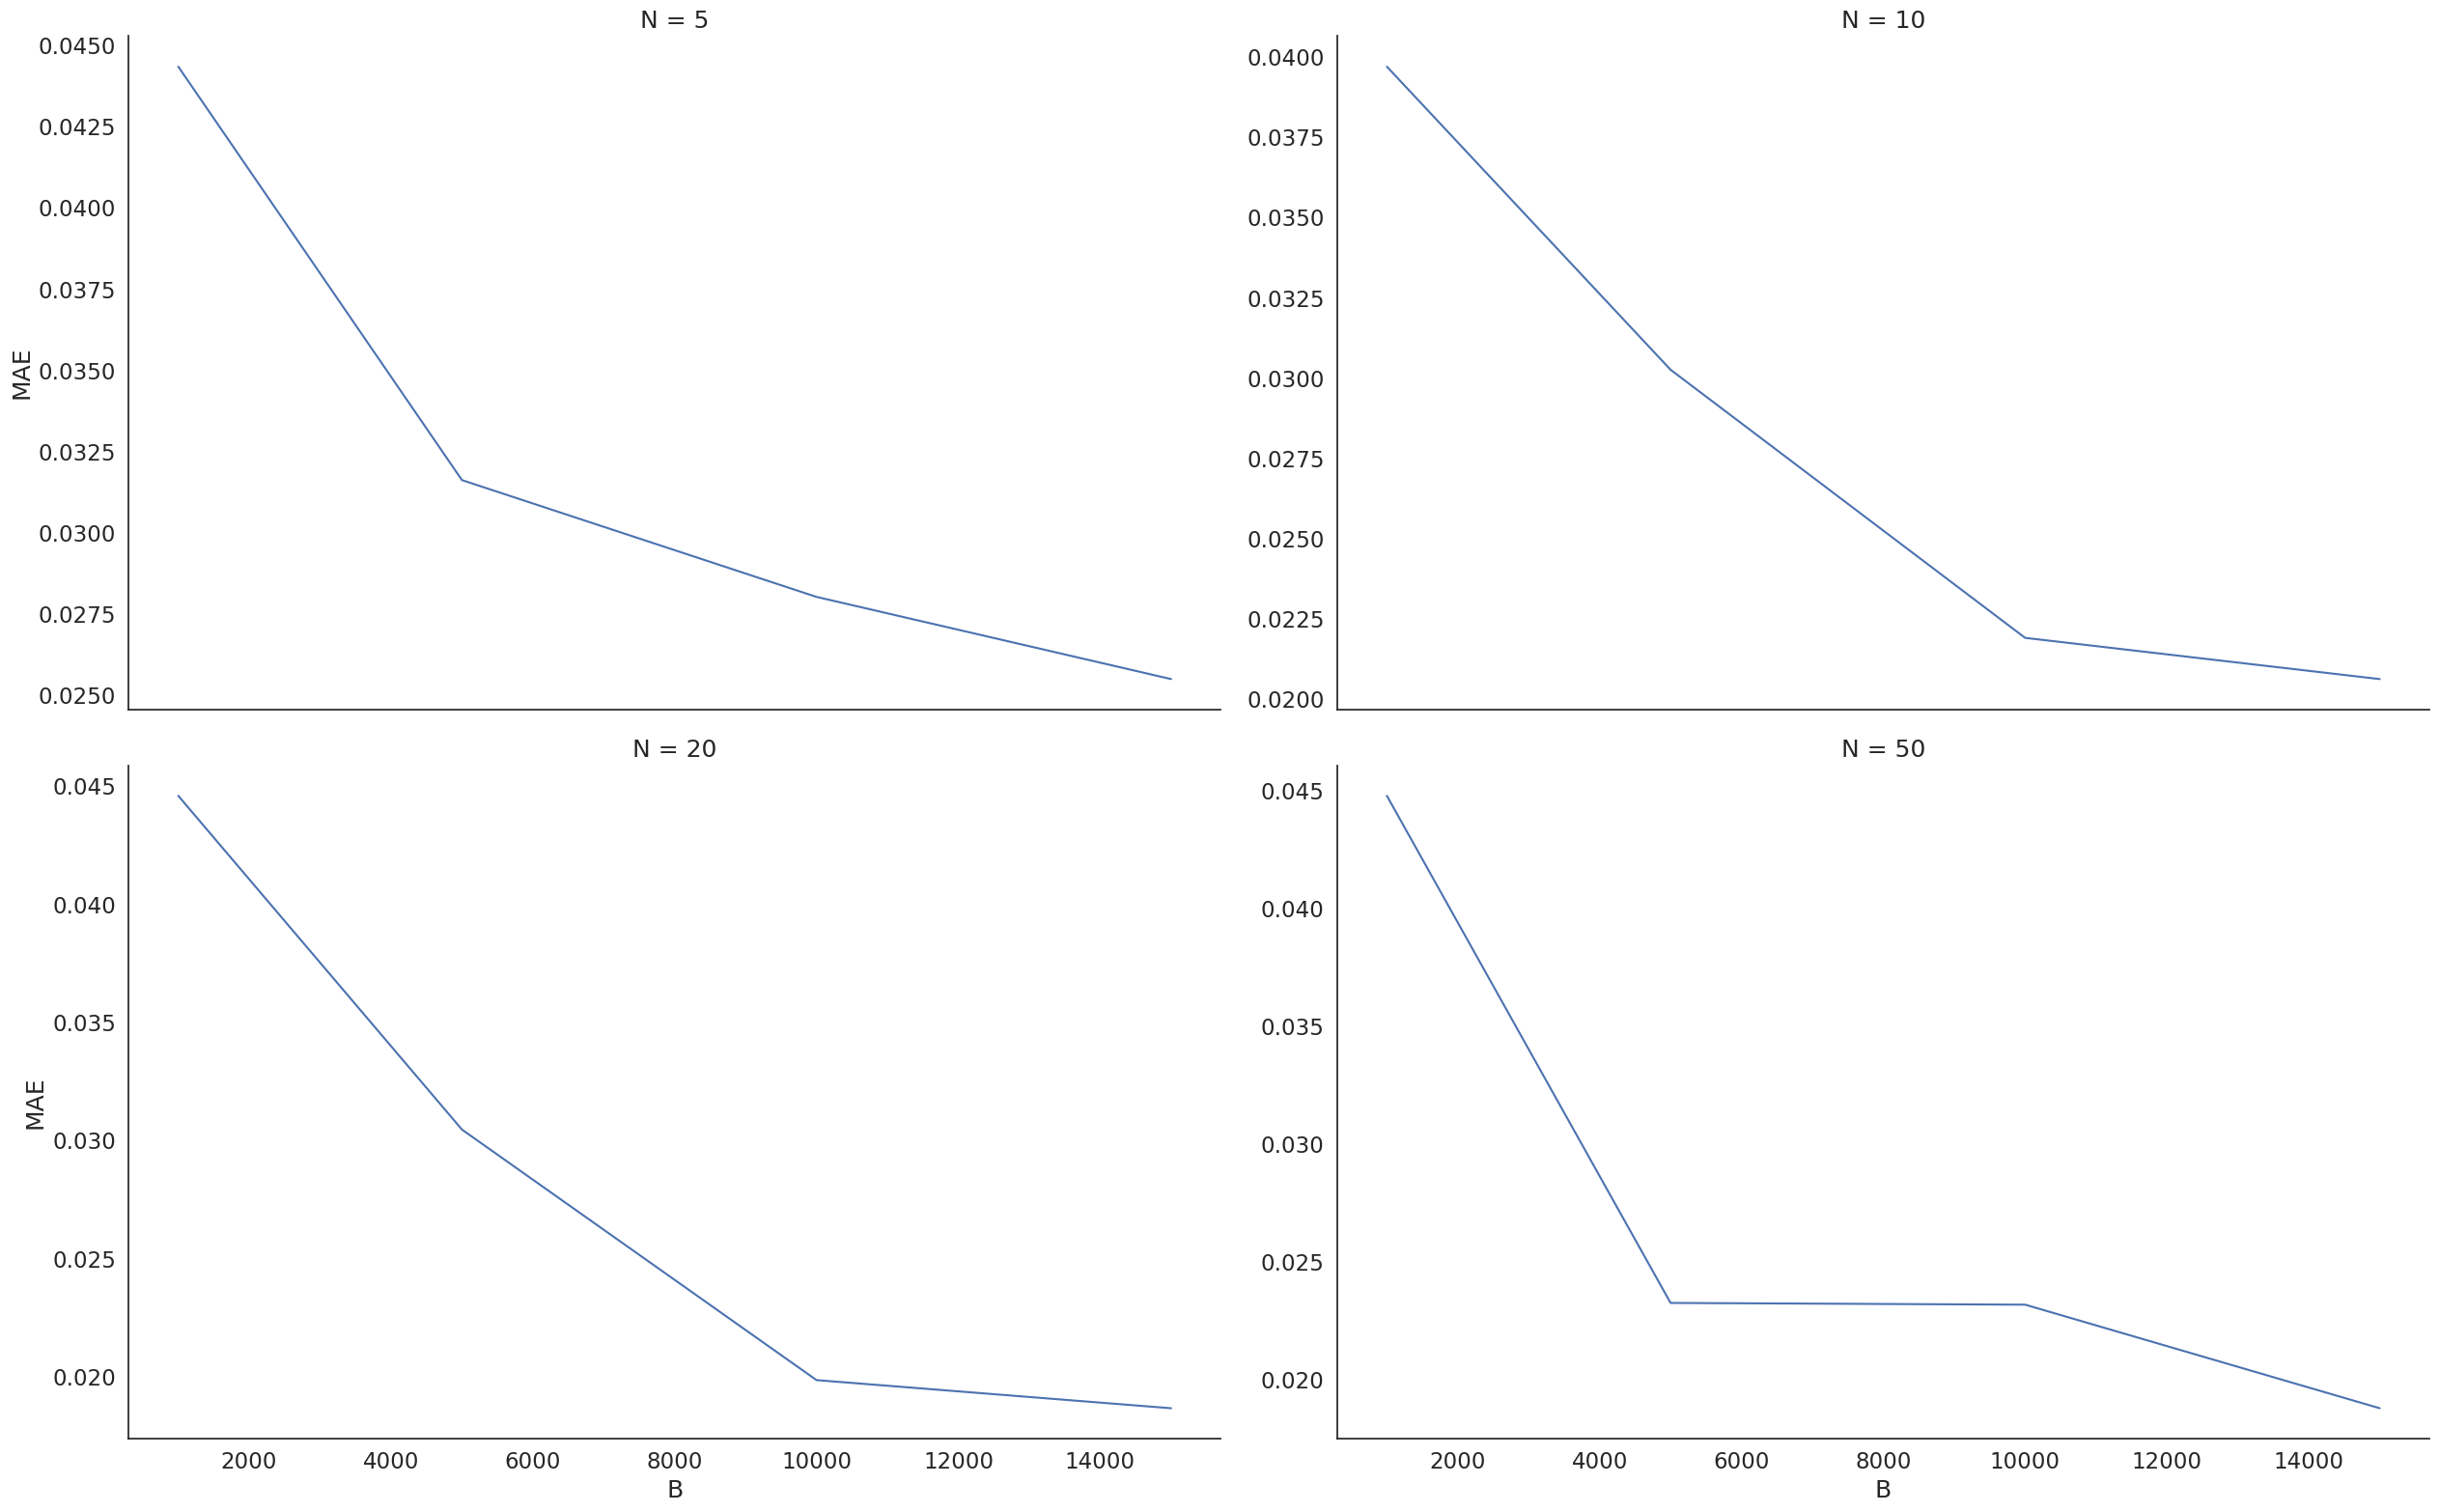

In [60]:
palette = sns.color_palette(cc.glasbey, n_colors=12)
sns.set(style="white", font_scale=1.5)
g = sns.FacetGrid(
    stats_df,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.60,
    palette=palette,
    margin_titles=True,
    sharey=False,
)

g.map(sns.lineplot, "B", "MAE")
plt.tight_layout()
plt.show()